# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from perceiver import tokenize_data, CustomDataset, PerceiverBlock, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

def seed_worker(worker_id): #데이터로더 난수고정
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(42)
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS = 4 # 서브프로세스관리자 수. 난수생성과 관련있습니다. 일단은 4로 고정합니다.


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

class CustomDataset(Dataset):
    """
    텍스트 전용. Dict 형태(batch['input_ids'], batch['labels'] 등)로 반환
    """
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

class PerceiverBlock(nn.Module):
    """
    - Cross Attention (latents -> x)
    - Self Attention (latent들 끼리)
    - Residual, LayerNorm, MLP(FeedForward) 등 포함
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # Cross Attention
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)

        # Self Attention 여러 층
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태
        # 1) Cross Attention
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents
        latents = self.cross_ln(latents)

        # 2) Self Attention 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 Residual/LayerNorm 처리

        return latents

class Perceiver(nn.Module):
    """
    - input_projection: (F -> latent_dim)
    - latents (latent_size, latent_dim): learnable
    - 여러 PerceiverBlock 반복
    - output_layer: (latent_dim -> num_classes)

    x: (B, T, F)
    """
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward_to_latent(self, x):
        """
        Perceiver의 최종 분류 레이어 전, (B, latent_dim) 형태의 임베딩만 반환
        """
        B, T, F = x.size()
        # 1) input projection
        x = self.input_projection(x)  # (B, T, latent_dim)

        # latents 초기화 -> (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention 호환 위해 (T, B, latent_dim)
        x = x.permute(1, 0, 2)
        latents = latents.permute(1, 0, 2)

        # PerceiverBlock 반복
        for block in self.blocks:
            latents = block(latents, x)

        # (latent_size, B, latent_dim) -> (B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)
        return latents

    def forward(self, x):
        """
        (B, T, F) -> 최종 (B, num_classes)
        """
        latents = self.forward_to_latent(x)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    """
    - BERT 임베딩(Embedding) 대신, torch.nn.Embedding + Perceiver
    - forward: (B, T) -> (B, num_classes)
    - get_text_latent: (B, T) -> (B, latent_dim)
    """
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model  # 수정된 Perceiver

    def forward(self, input_ids):
        # (B, T) -> (B, T, embed_dim)
        embeddings = self.embedding(input_ids)
        # (B, T, embed_dim) -> Perceiver -> (B, num_classes)
        return self.perceiver(embeddings)

    def get_text_latent(self, input_ids):
        # 임베딩만 해서 (B, T, embed_dim), Perceiver -> (B, latent_dim)
        embeddings = self.embedding(input_ids)
        return self.perceiver.forward_to_latent(embeddings)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/youlee/perceiver/perceiver/model'
loader_path = '/home/youlee/perceiver/perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False,
                            num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9117, train acc: 0.5536
                               test loss: 0.5913, test acc: 0.7682
    epoch 5/15: train loss: 0.2139, train acc: 0.9341
                               test loss: 0.4760, test acc: 0.8560
    epoch 10/15: train loss: 0.0447, train acc: 0.9902
                               test loss: 0.6848, test acc: 0.8553
    epoch 15/15: train loss: 0.0180, train acc: 0.9971
                               test loss: 0.8607, test acc: 0.8519

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.8407, train acc: 0.6142
                               test loss: 0.5488, test acc: 0.8093
    epoch 5/15: train loss: 0.1962, train acc: 0.9369
                               test loss: 0.4529, test acc: 0.8539
    epoch 10/15: train loss: 0.0415, train acc: 0.9900
                               test loss: 0.7332, test acc: 0.8519
    epoch 15/15: train loss: 0.0210, train acc: 0.9962
                               test lo

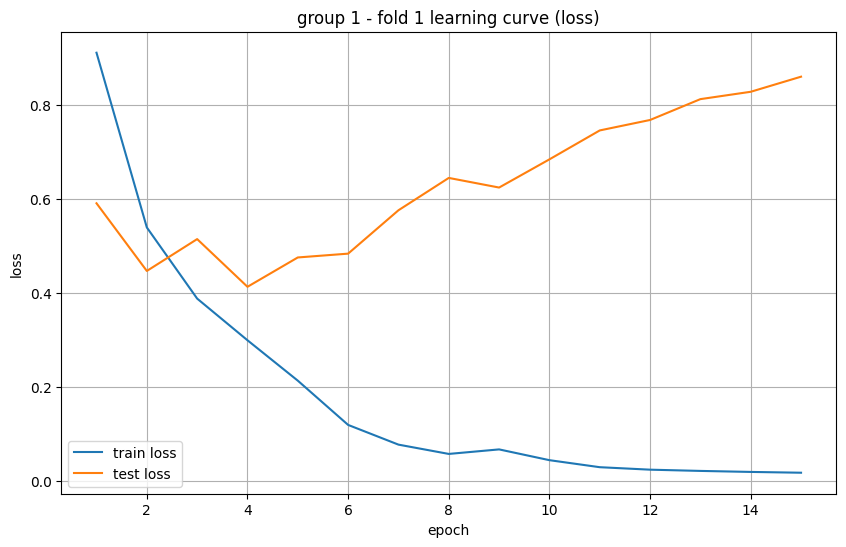

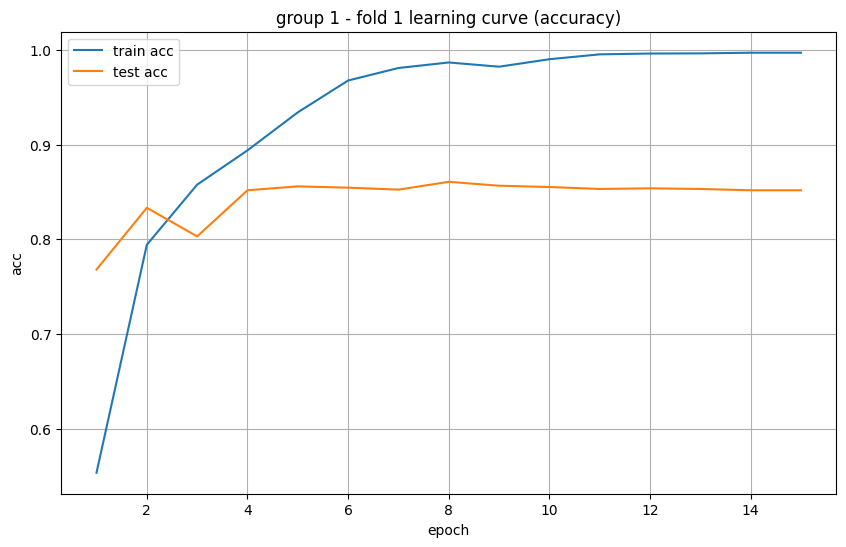

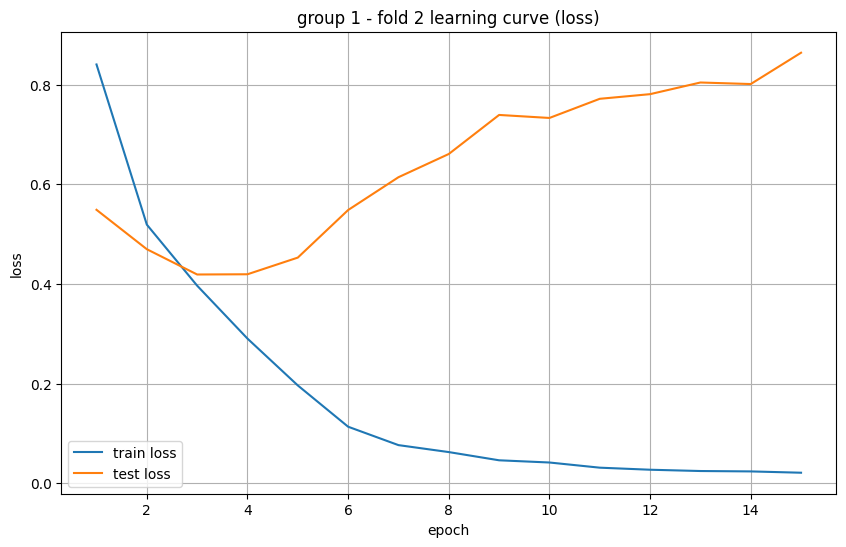

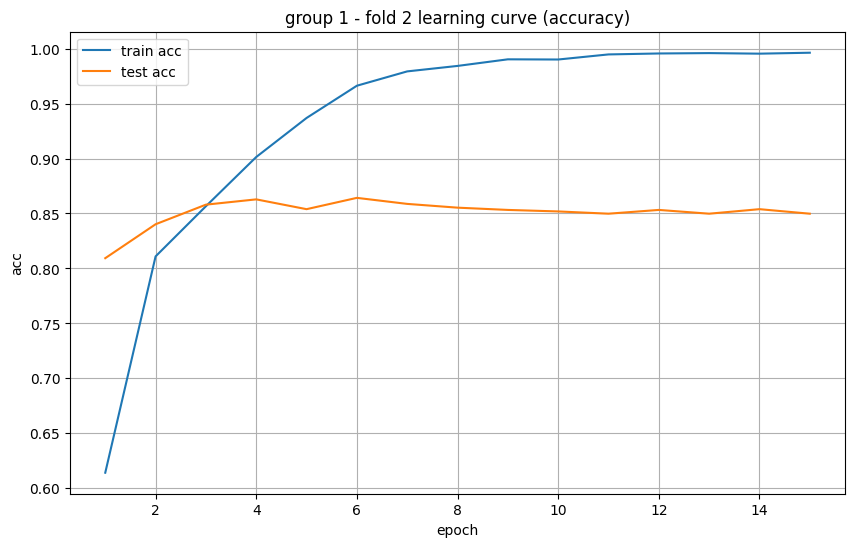

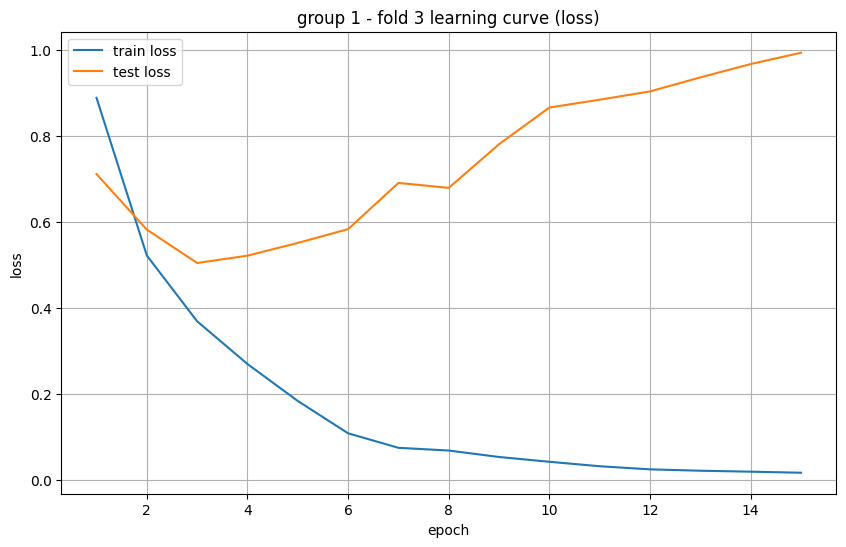

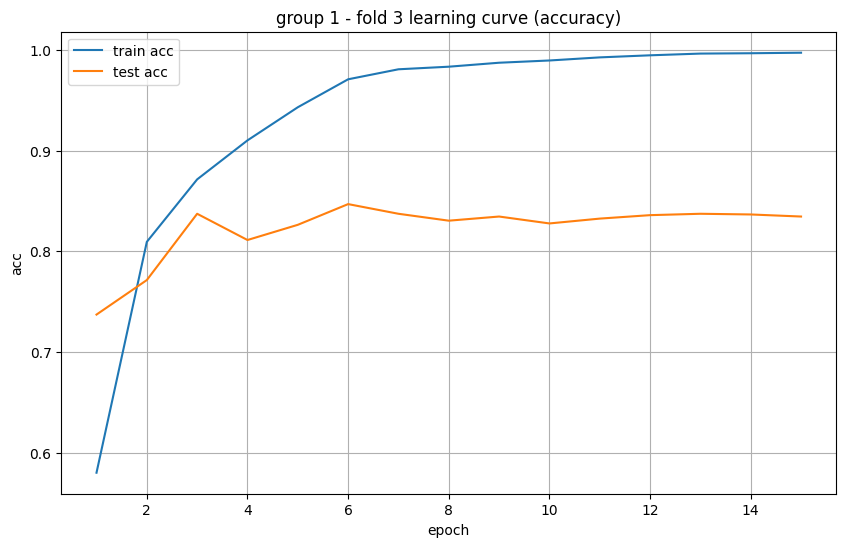

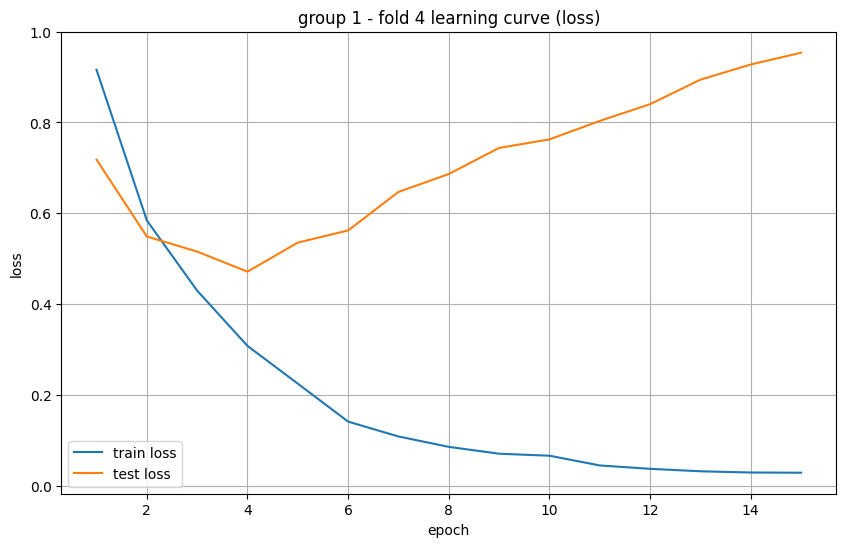

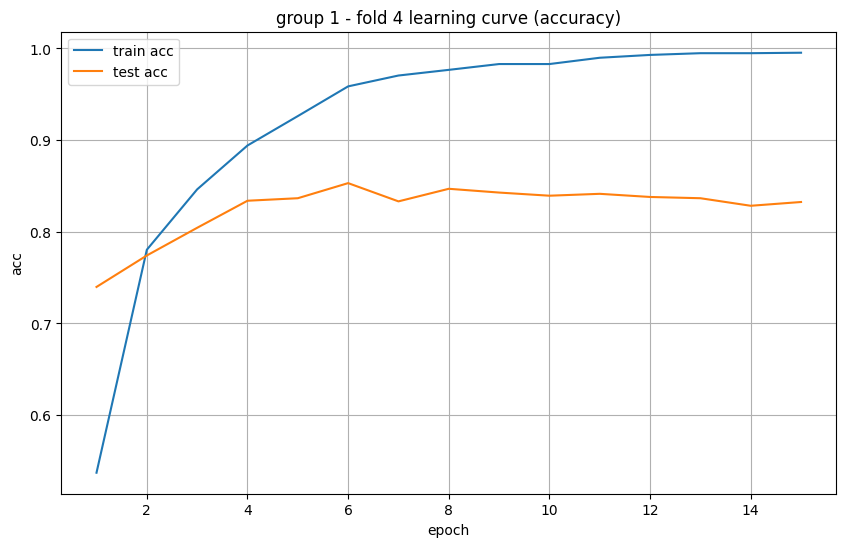

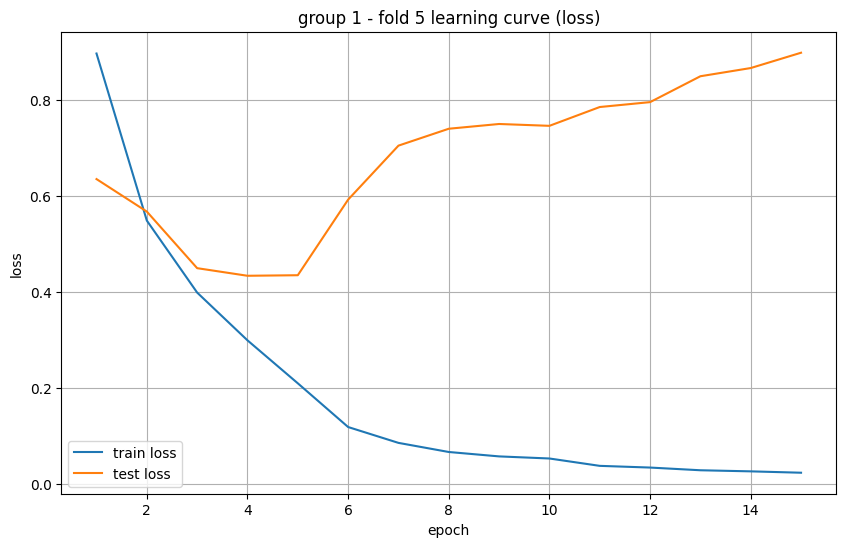

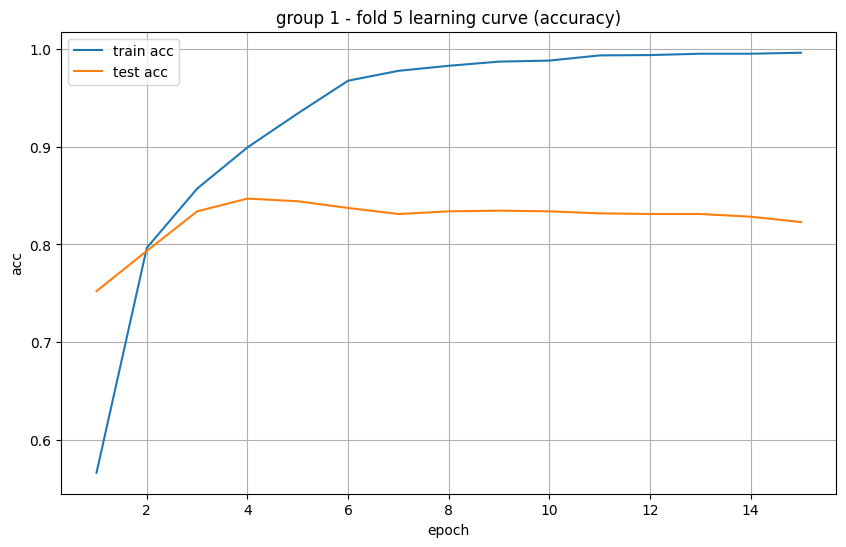

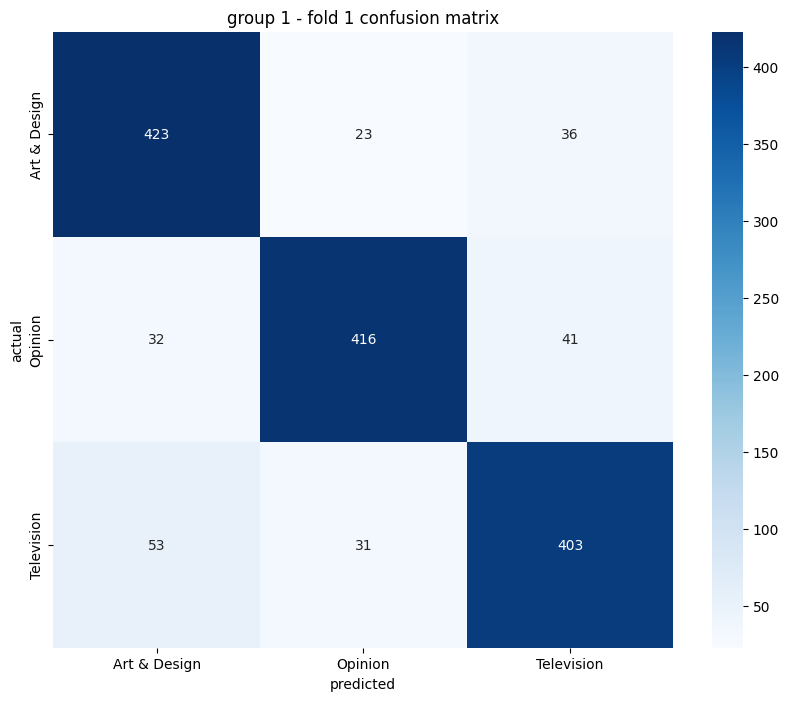

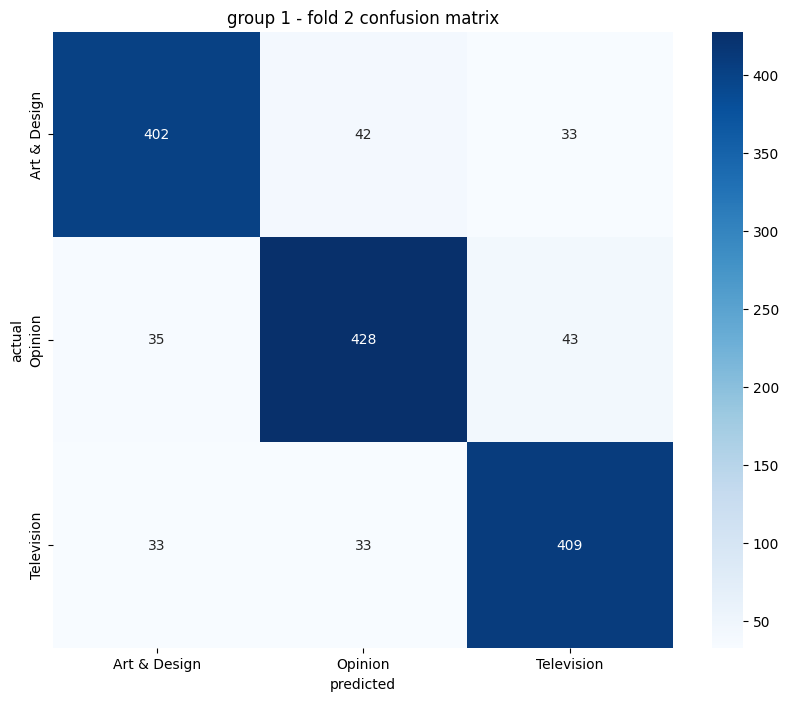

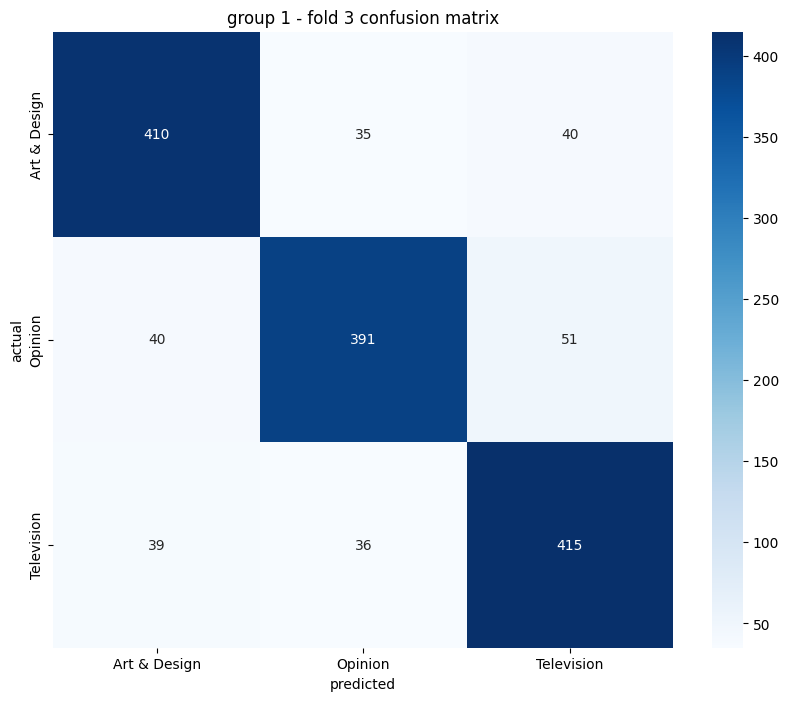

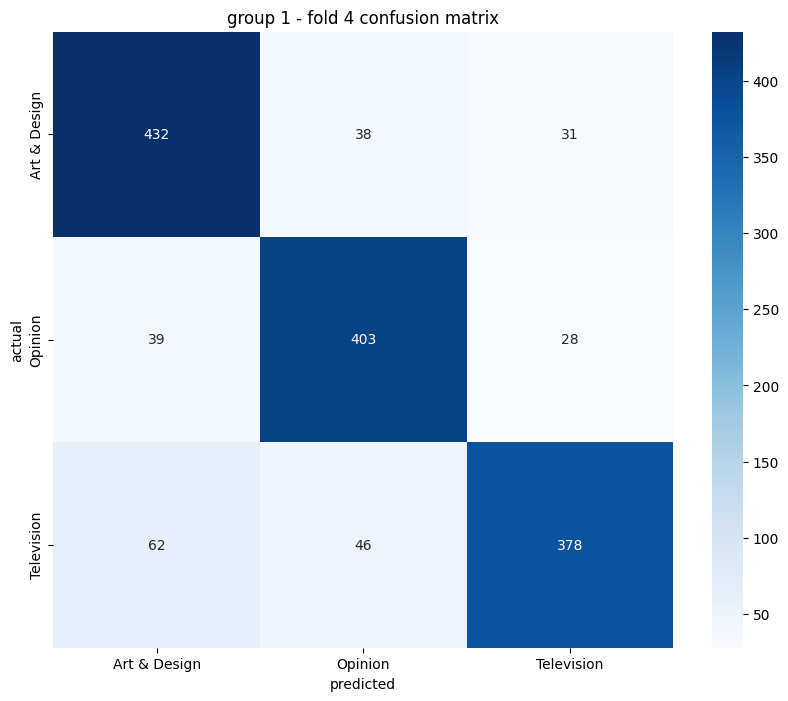

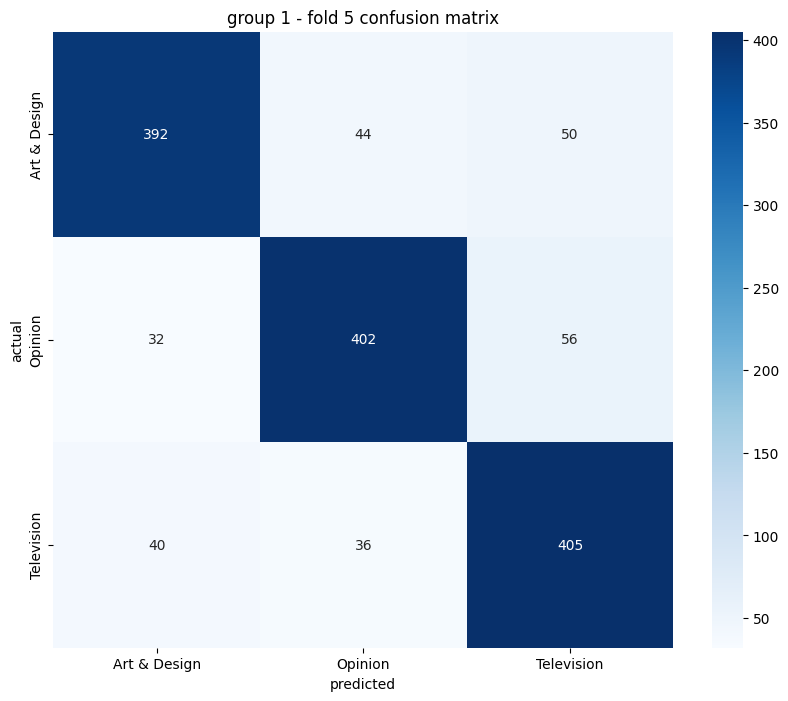


group 2 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0378, train acc: 0.4554
                               test loss: 1.0127, test acc: 0.5031
    epoch 5/15: train loss: 0.2195, train acc: 0.9294
                               test loss: 0.6118, test acc: 0.8102
    epoch 10/15: train loss: 0.0406, train acc: 0.9890
                               test loss: 0.9394, test acc: 0.8095
    epoch 15/15: train loss: 0.0066, train acc: 0.9984
                               test loss: 1.1072, test acc: 0.8171

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0791, train acc: 0.4065
                               test loss: 0.8636, test acc: 0.6128
    epoch 5/15: train loss: 0.2137, train acc: 0.9313
                               test loss: 0.6438, test acc: 0.7874
    epoch 10/15: train loss: 0.0460, train acc: 0.9877
                               test loss: 1.1408, test acc: 0.7702
    epoch 15/15: train loss: 0.0180, train acc: 0.9974
                               test lo

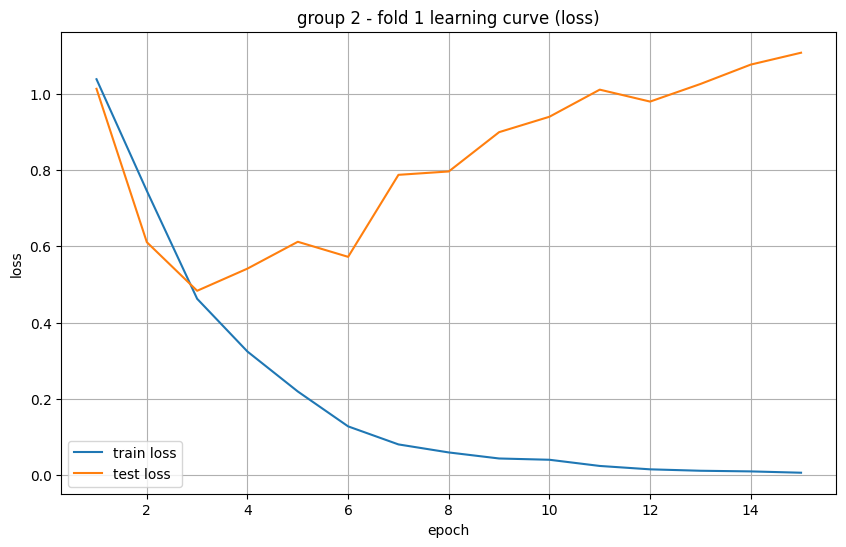

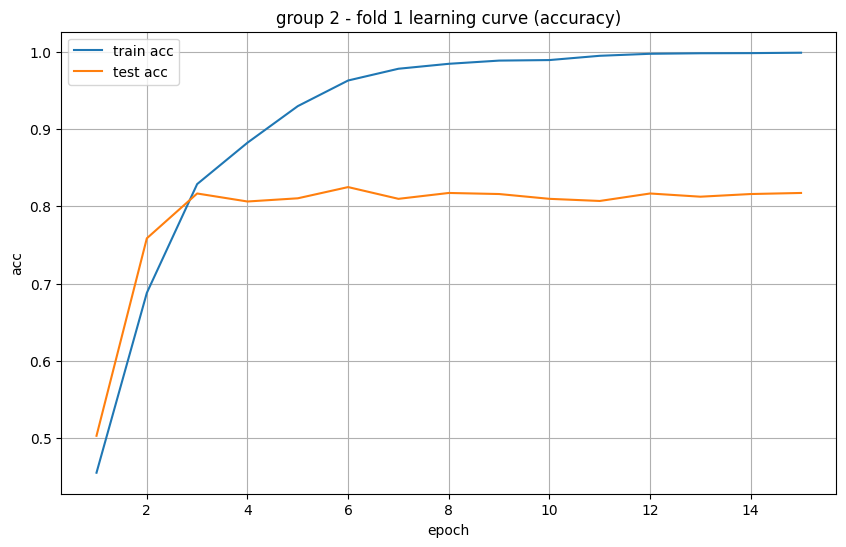

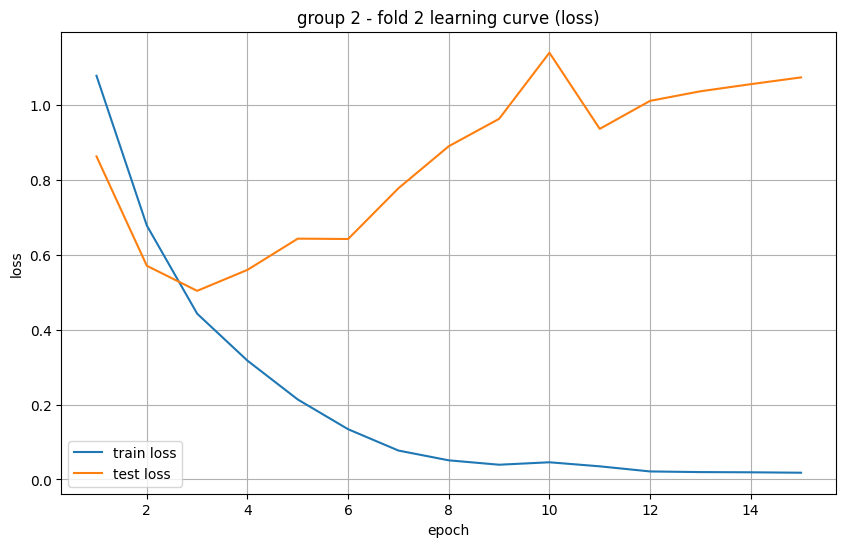

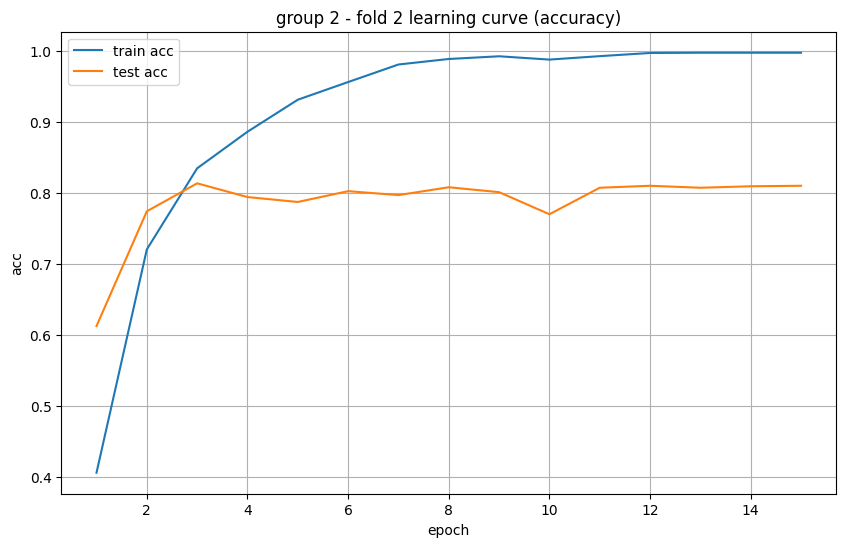

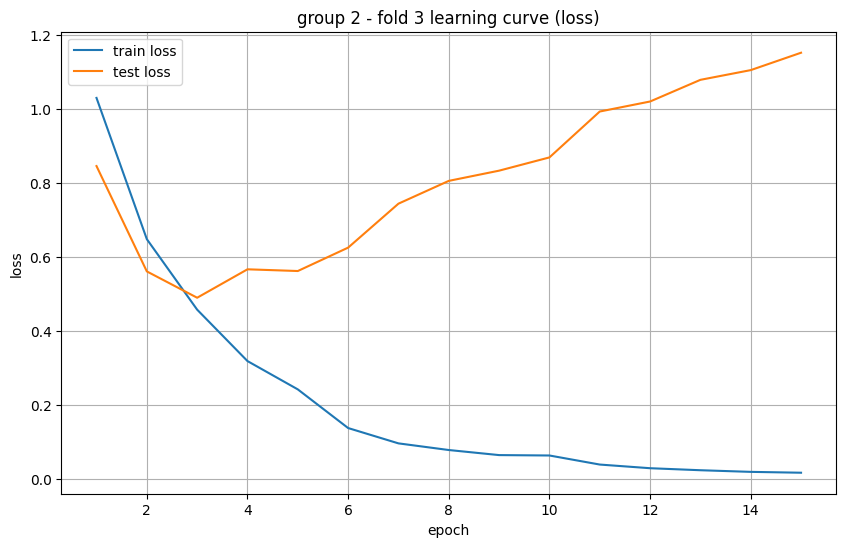

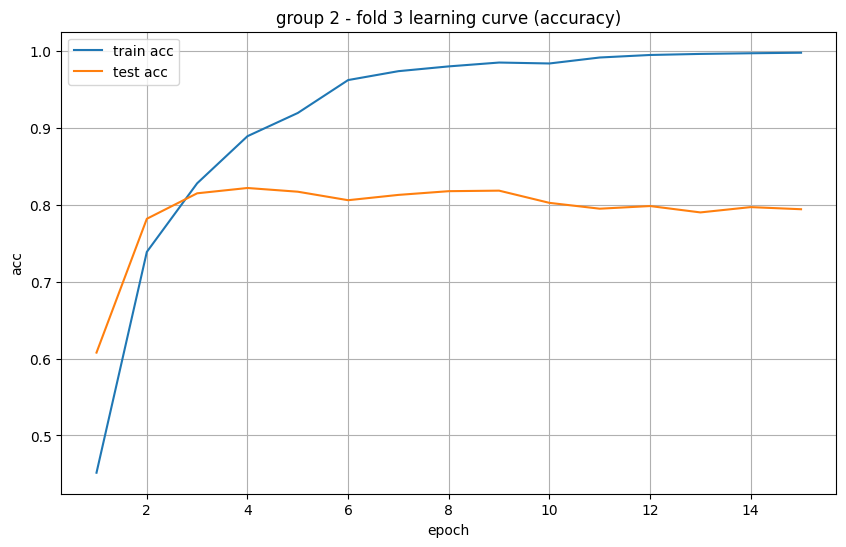

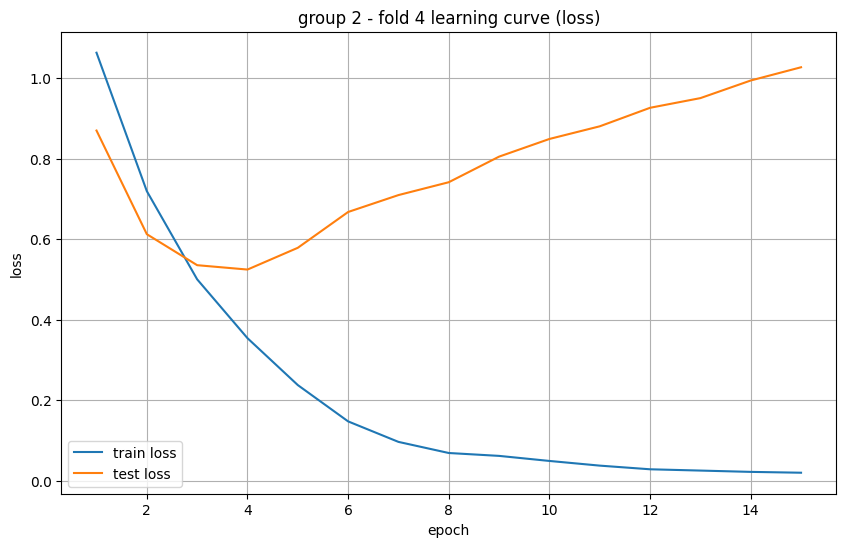

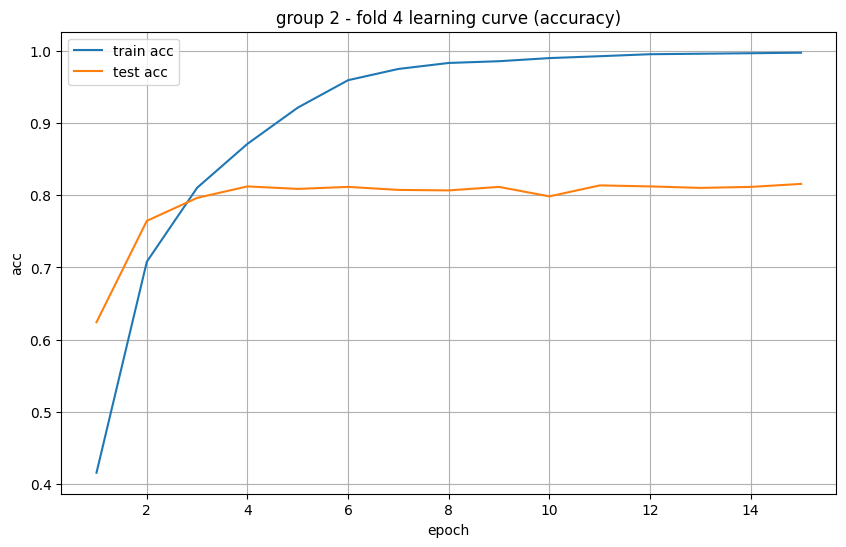

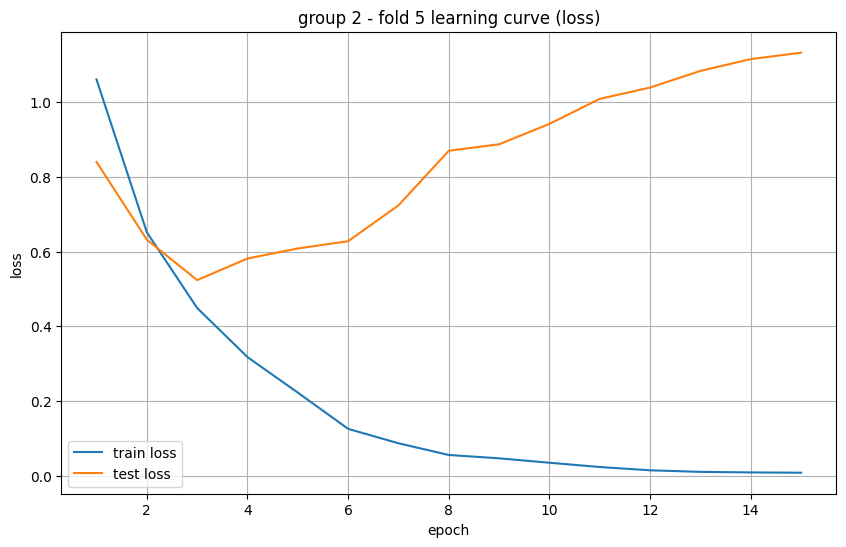

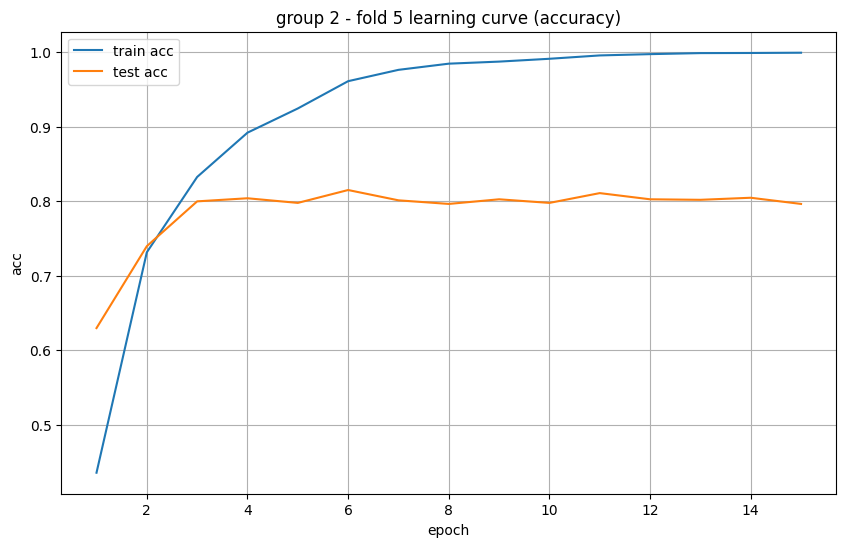

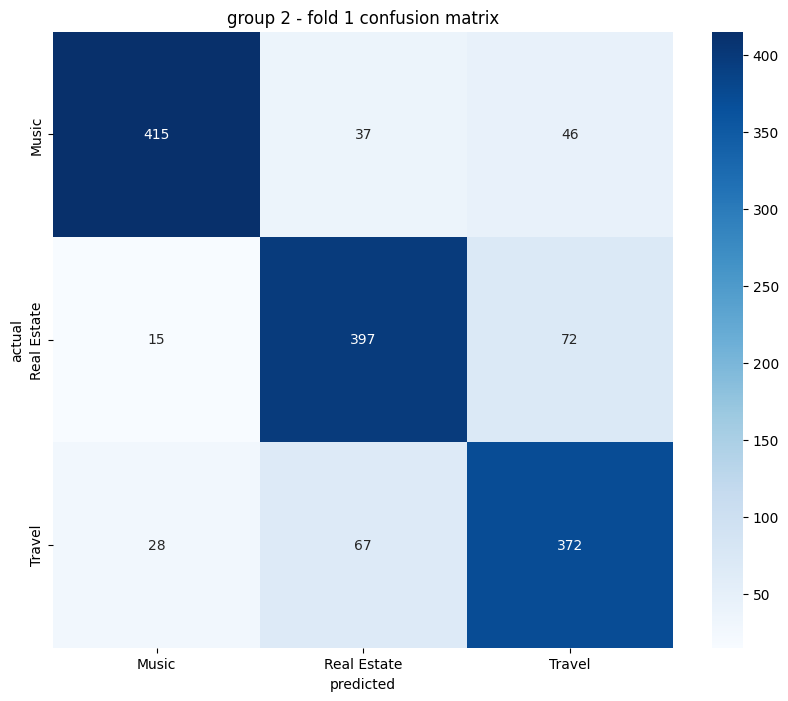

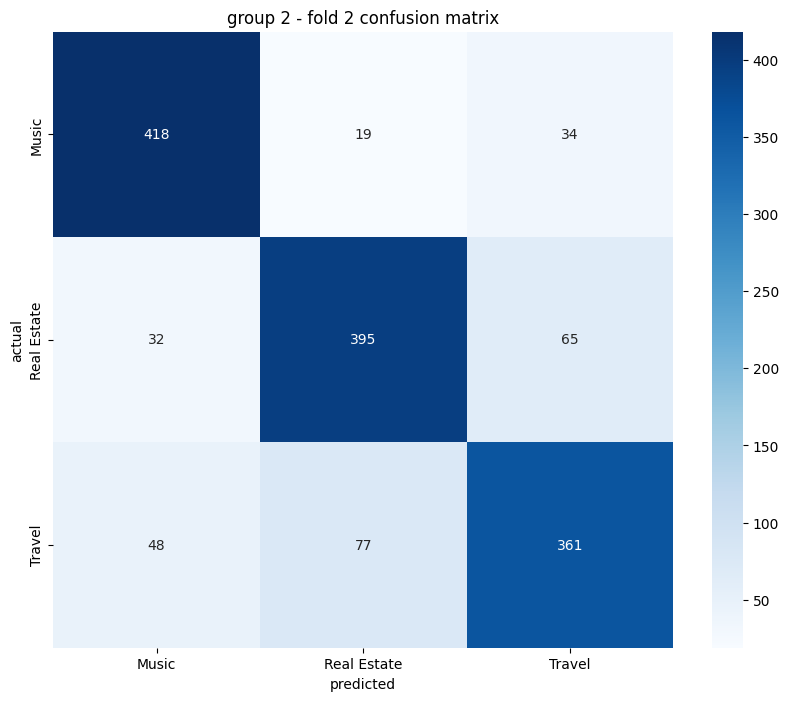

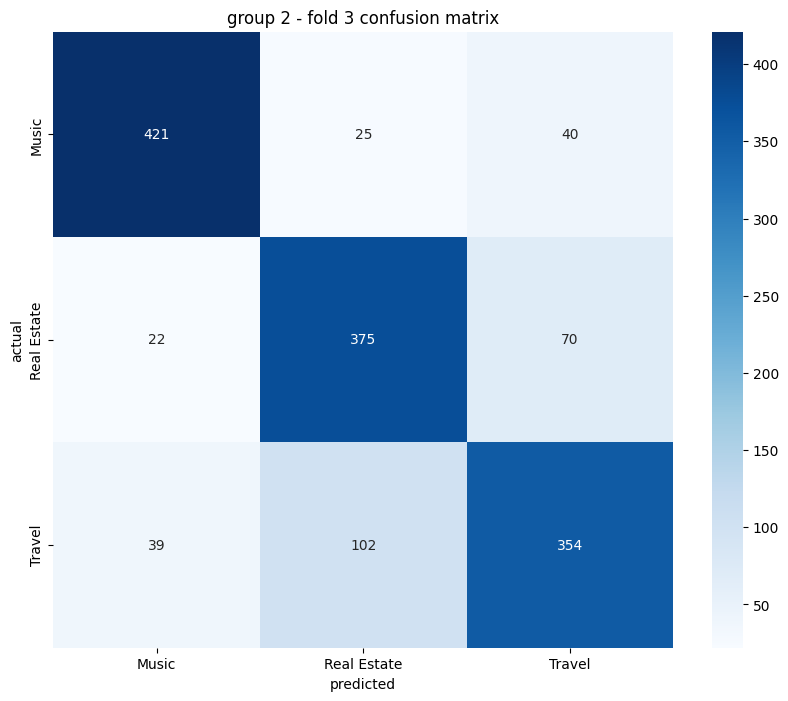

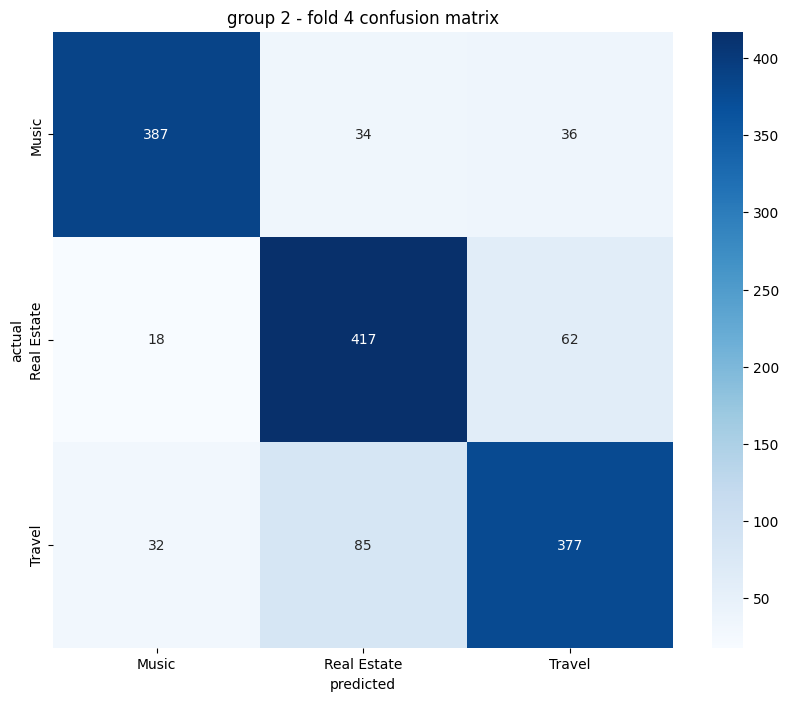

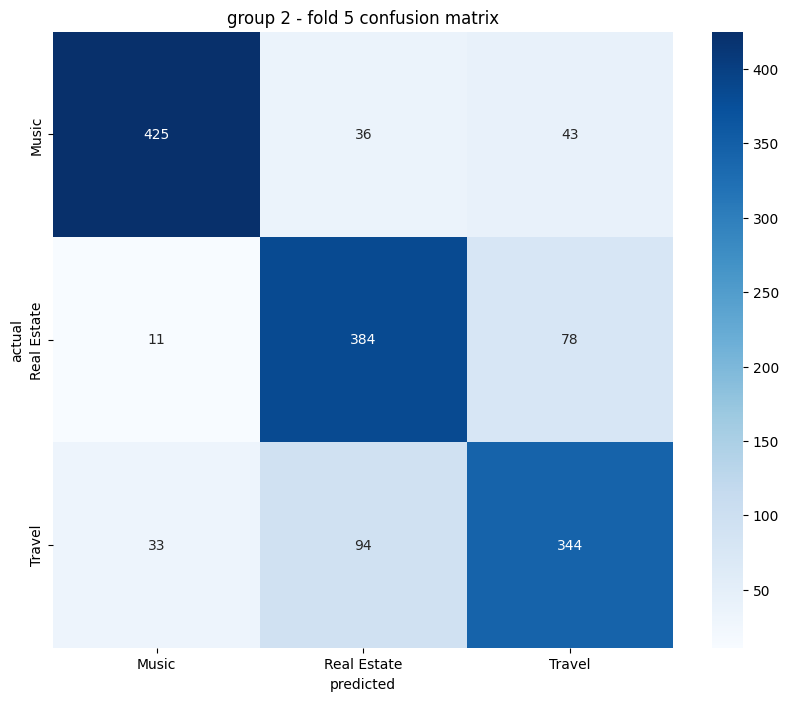


group 3 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.8793, train acc: 0.5951
                               test loss: 0.7505, test acc: 0.7082
    epoch 5/15: train loss: 0.2107, train acc: 0.9314
                               test loss: 0.4635, test acc: 0.8444
    epoch 10/15: train loss: 0.0483, train acc: 0.9857
                               test loss: 0.7662, test acc: 0.8237
    epoch 15/15: train loss: 0.0099, train acc: 0.9984
                               test loss: 1.0069, test acc: 0.8237

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9794, train acc: 0.5005
                               test loss: 0.6546, test acc: 0.7241
    epoch 5/15: train loss: 0.2302, train acc: 0.9238
                               test loss: 0.4308, test acc: 0.8416
    epoch 10/15: train loss: 0.0478, train acc: 0.9863
                               test loss: 0.7291, test acc: 0.8375
    epoch 15/15: train loss: 0.0105, train acc: 0.9979
                               test lo

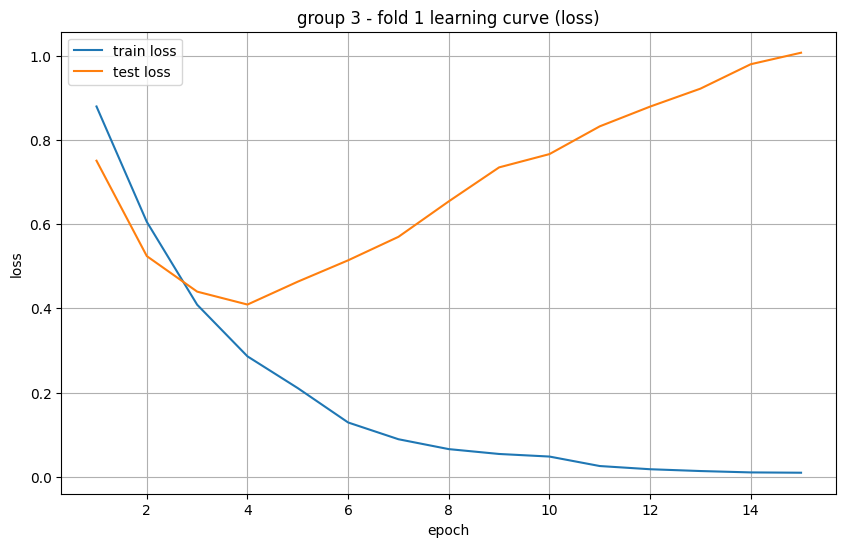

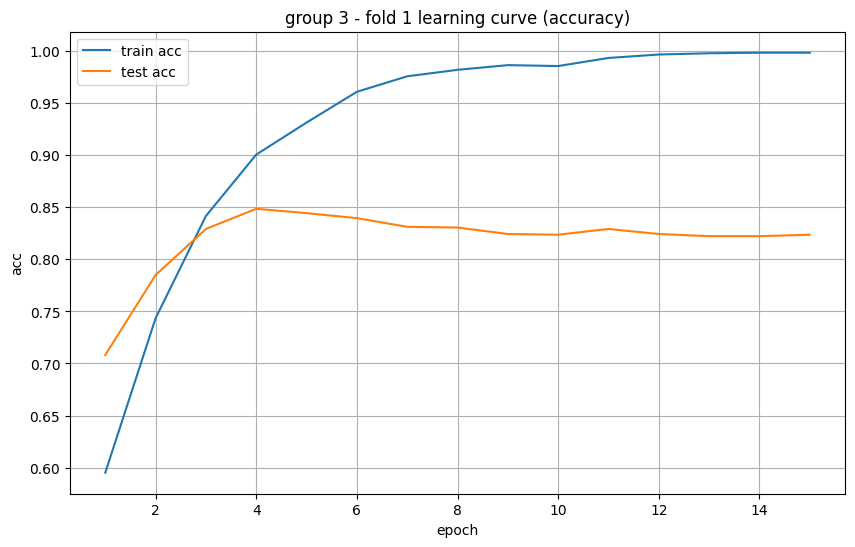

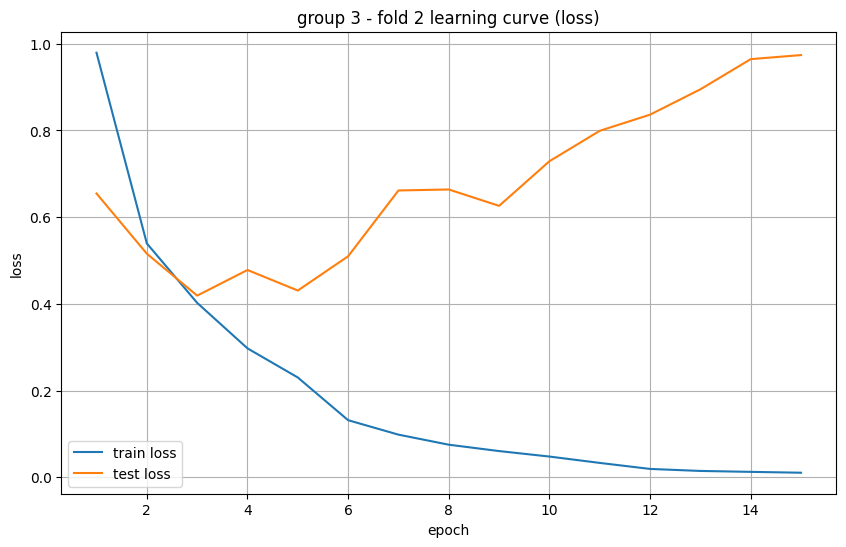

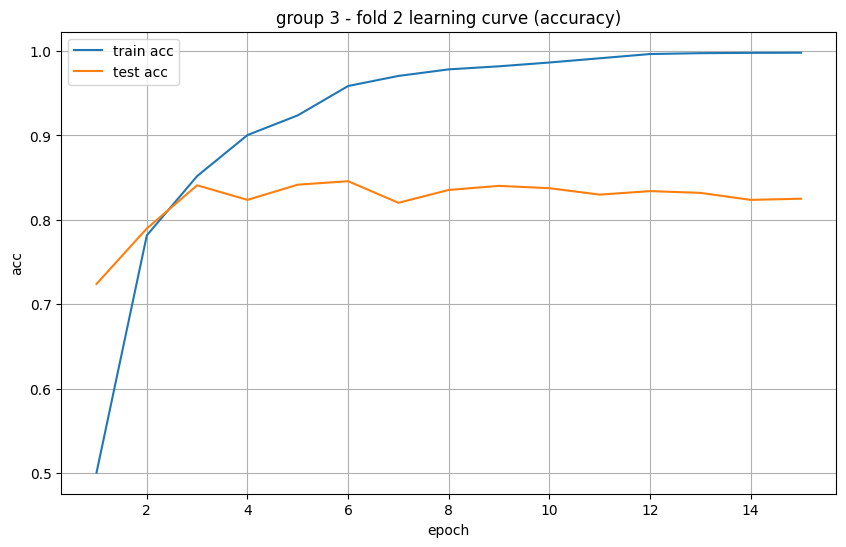

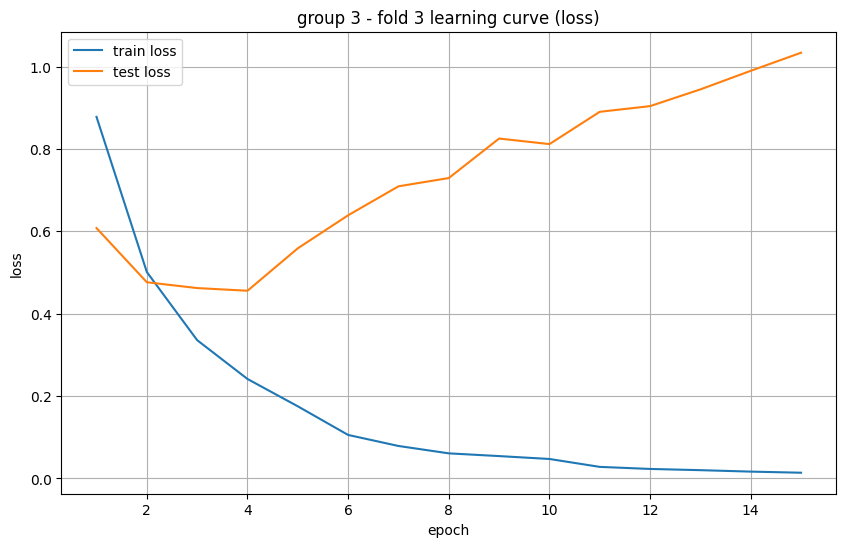

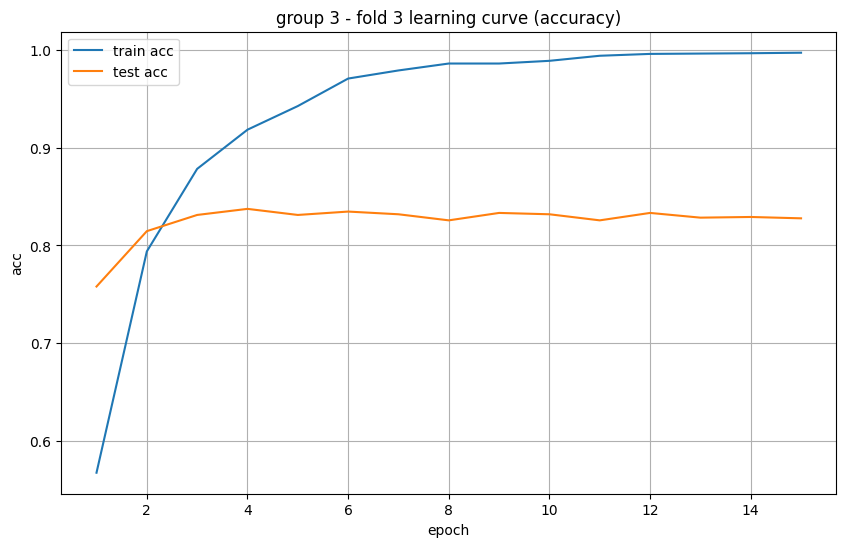

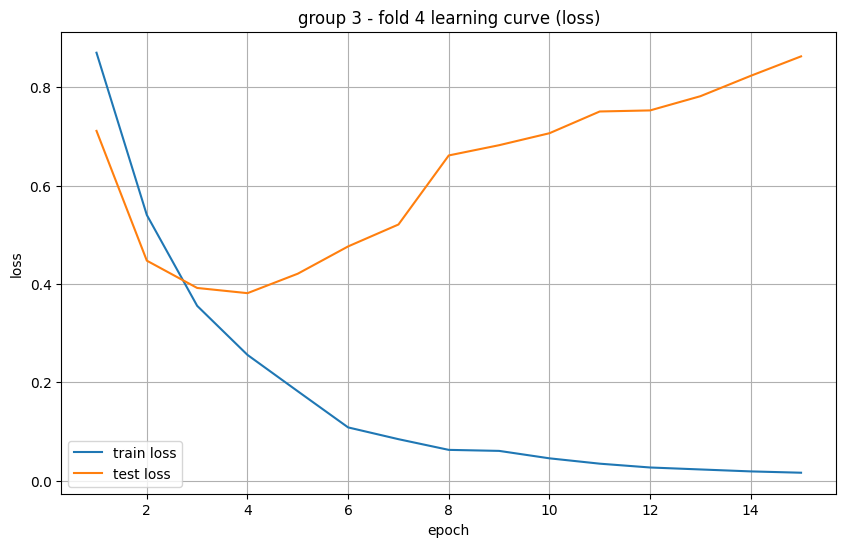

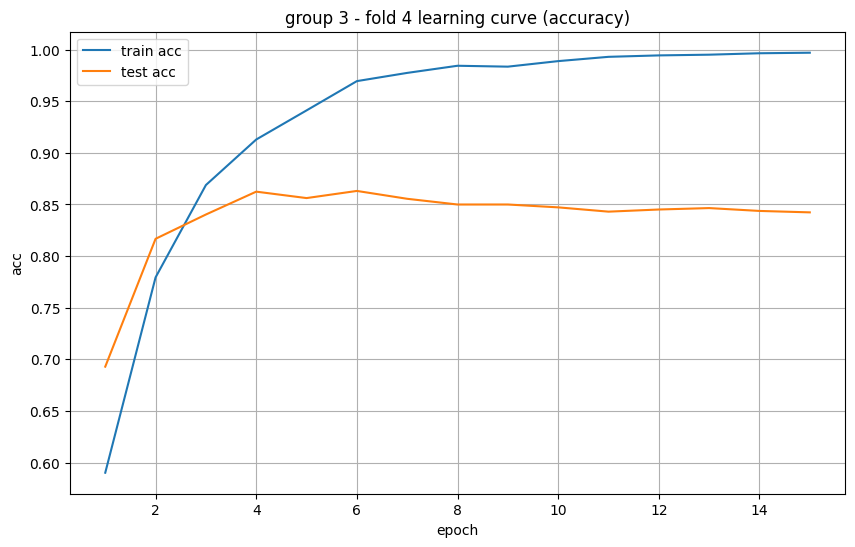

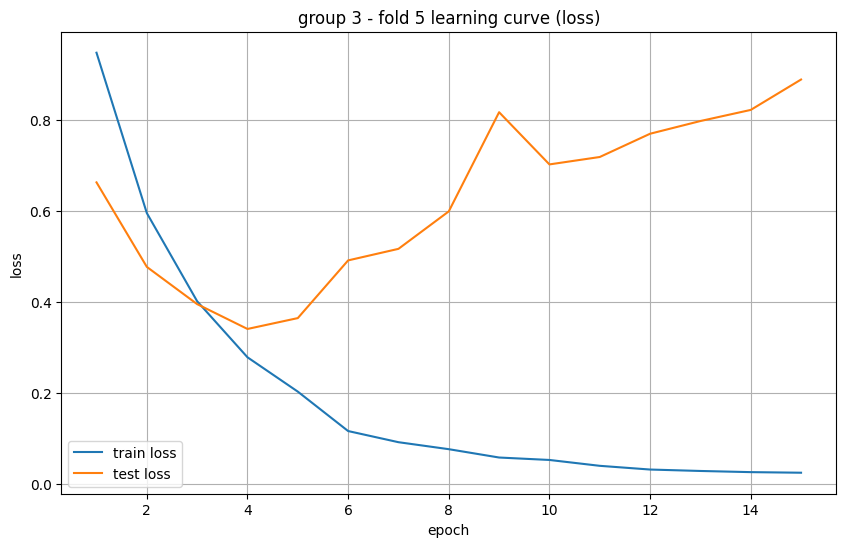

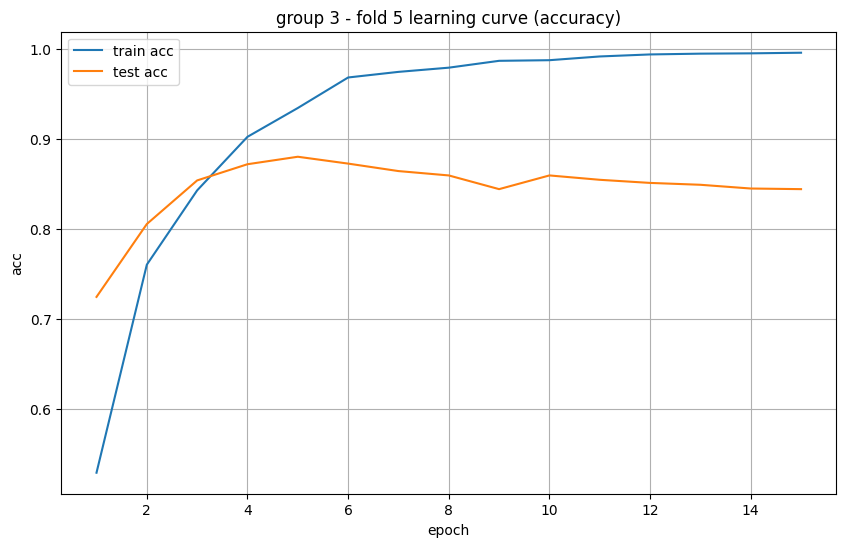

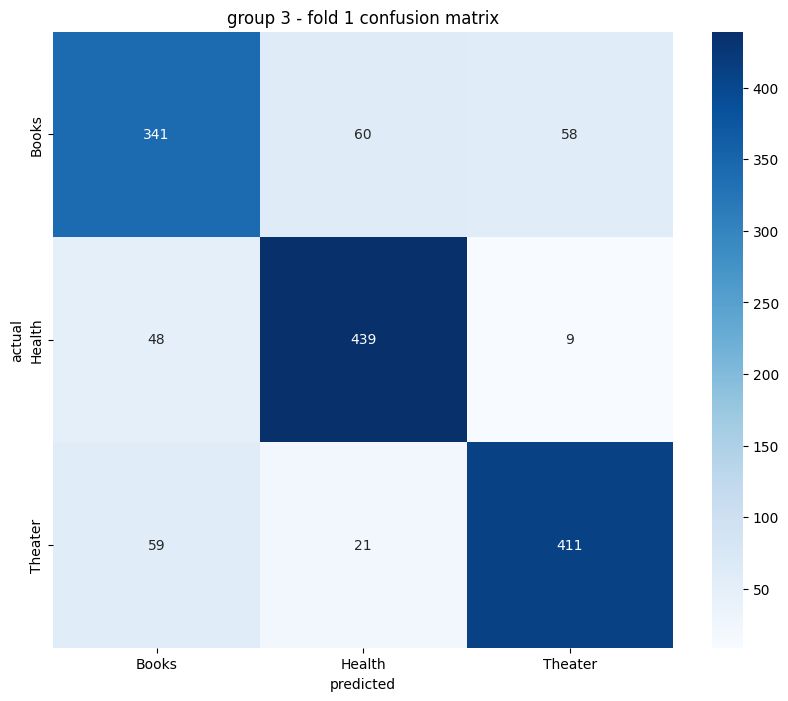

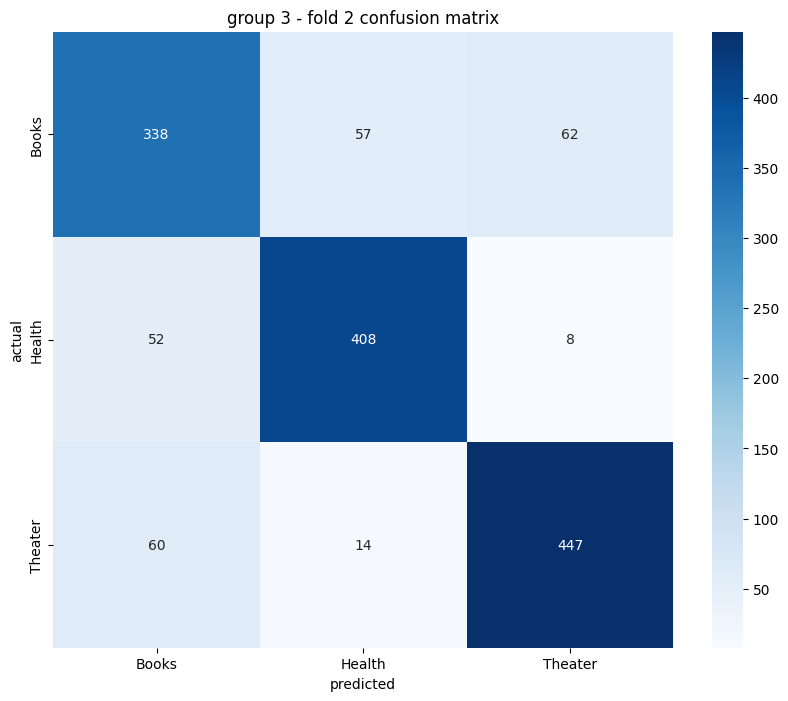

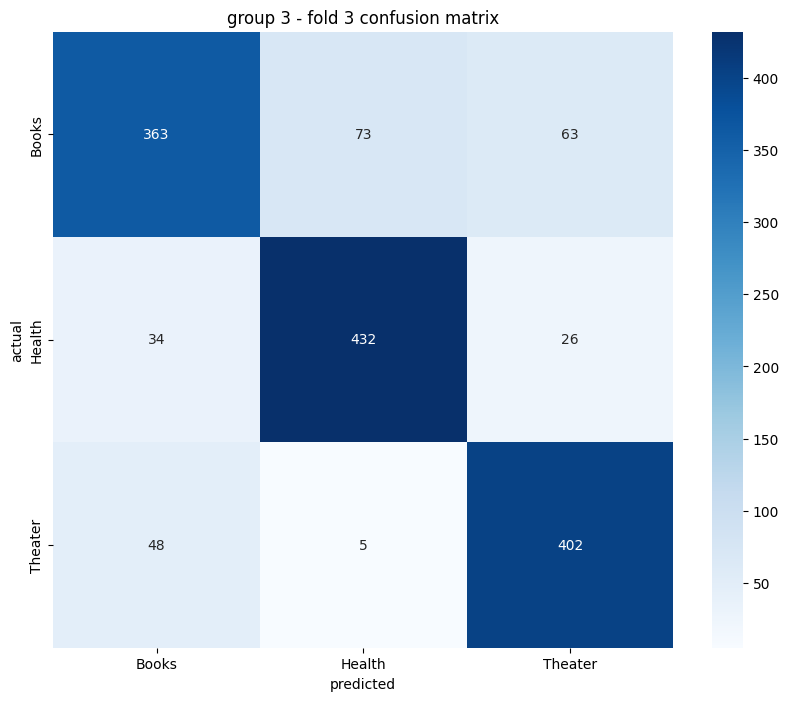

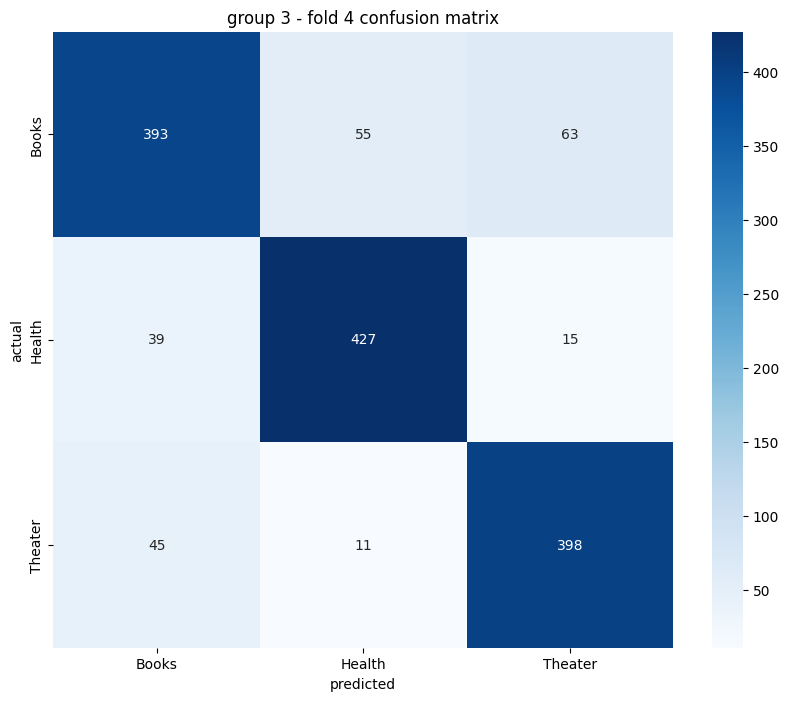

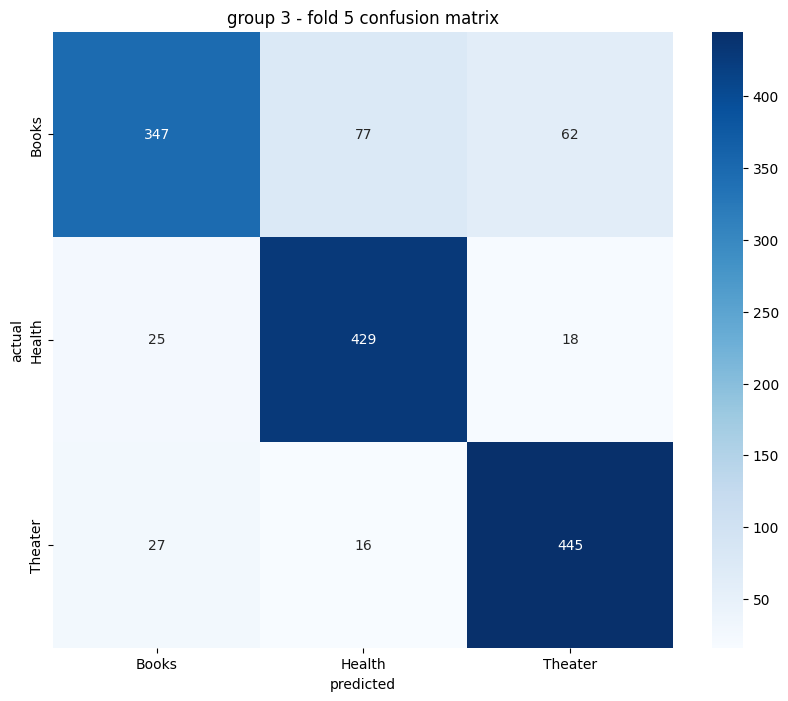


group 4 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0288, train acc: 0.4433
                               test loss: 0.9376, test acc: 0.5613
    epoch 5/15: train loss: 0.1367, train acc: 0.9558
                               test loss: 0.4361, test acc: 0.8538
    epoch 10/15: train loss: 0.0247, train acc: 0.9937
                               test loss: 0.7048, test acc: 0.8531
    epoch 15/15: train loss: 0.0058, train acc: 0.9993
                               test loss: 0.8510, test acc: 0.8531

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0334, train acc: 0.4602
                               test loss: 0.8369, test acc: 0.6058
    epoch 5/15: train loss: 0.1395, train acc: 0.9542
                               test loss: 0.4184, test acc: 0.8705
    epoch 10/15: train loss: 0.0271, train acc: 0.9937
                               test loss: 0.6052, test acc: 0.8572
    epoch 15/15: train loss: 0.0081, train acc: 0.9988
                               test lo

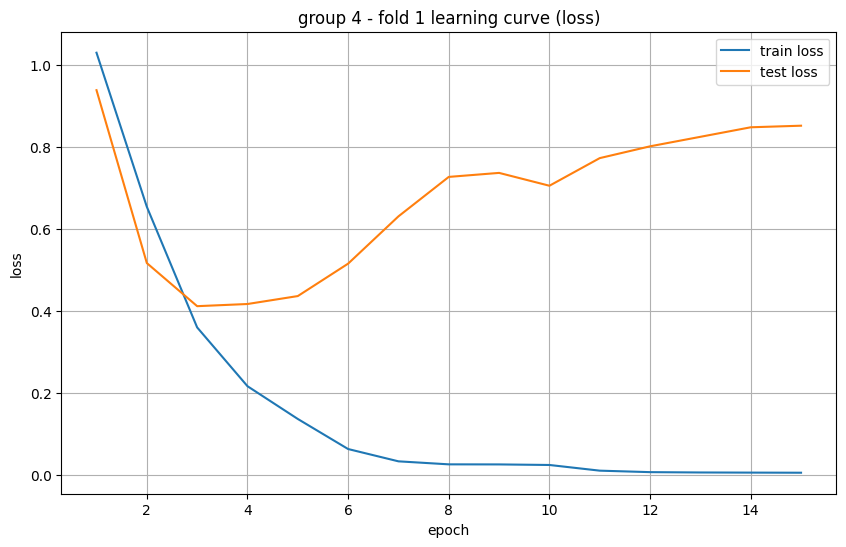

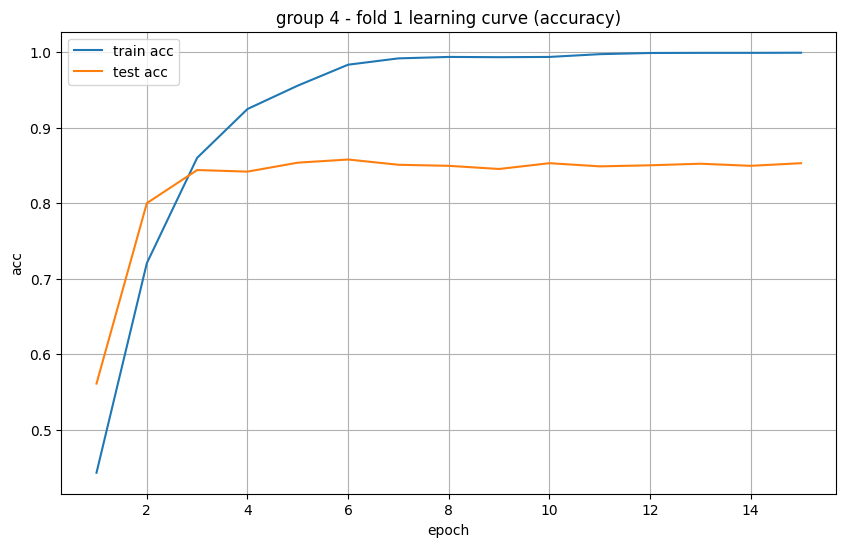

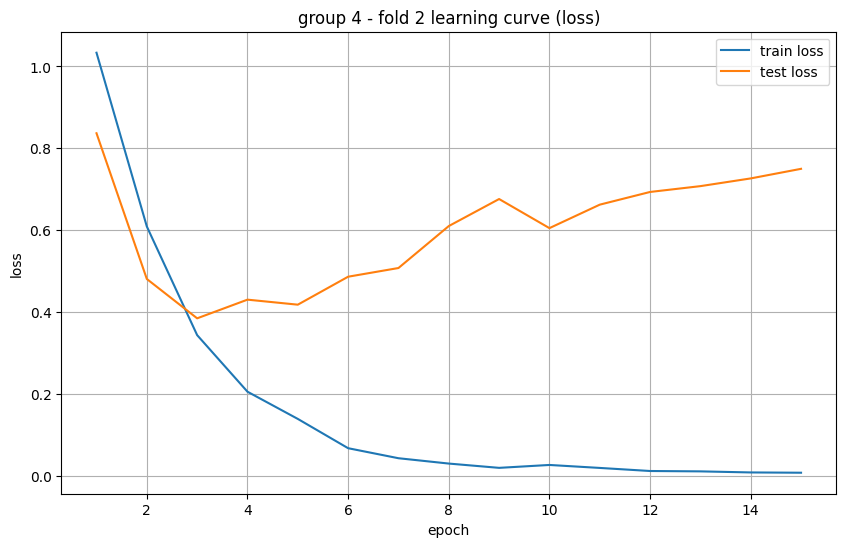

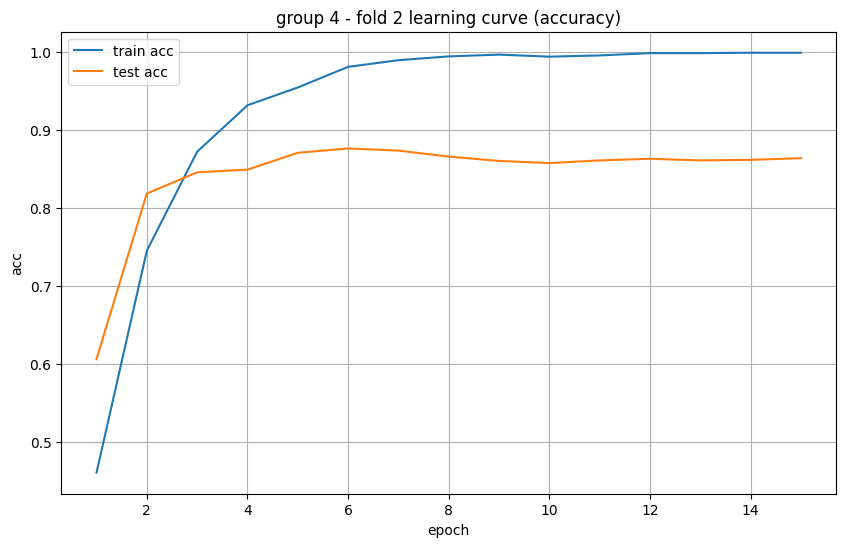

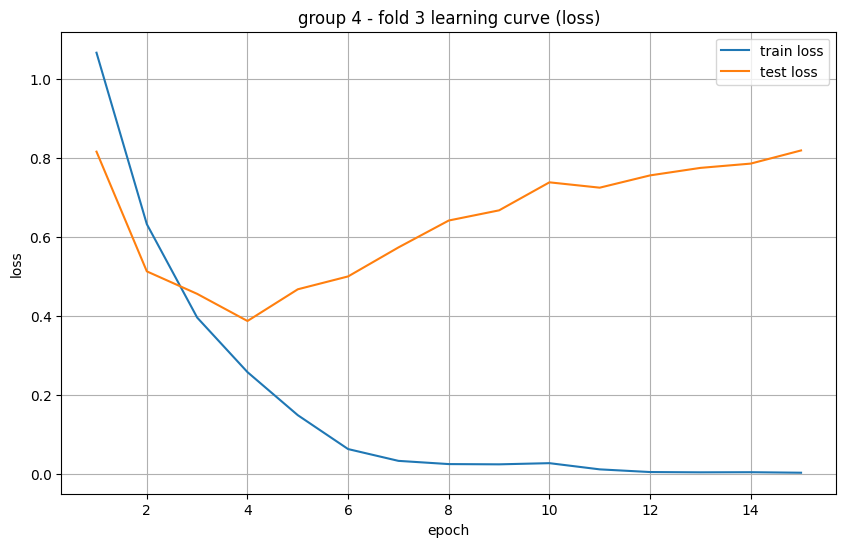

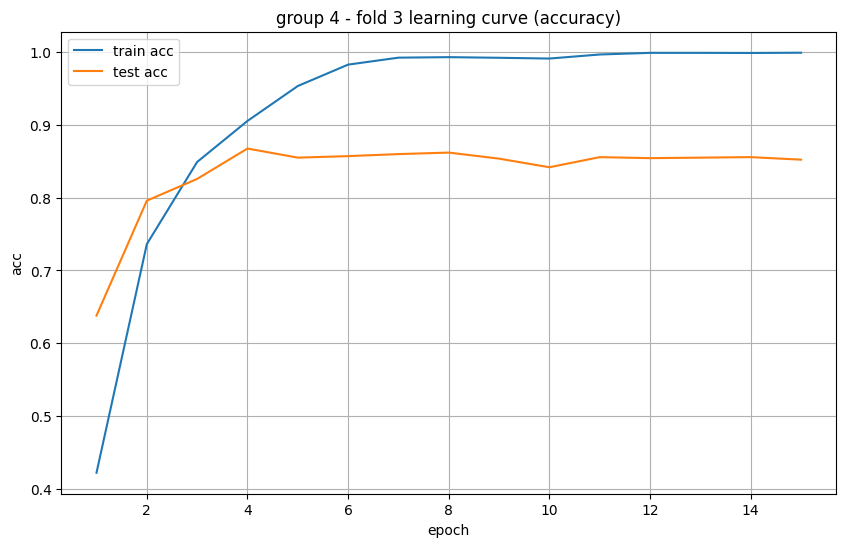

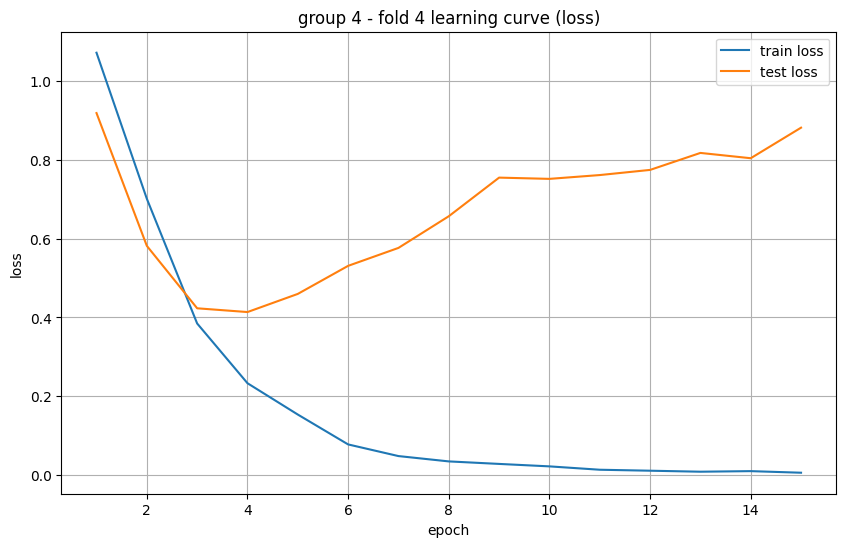

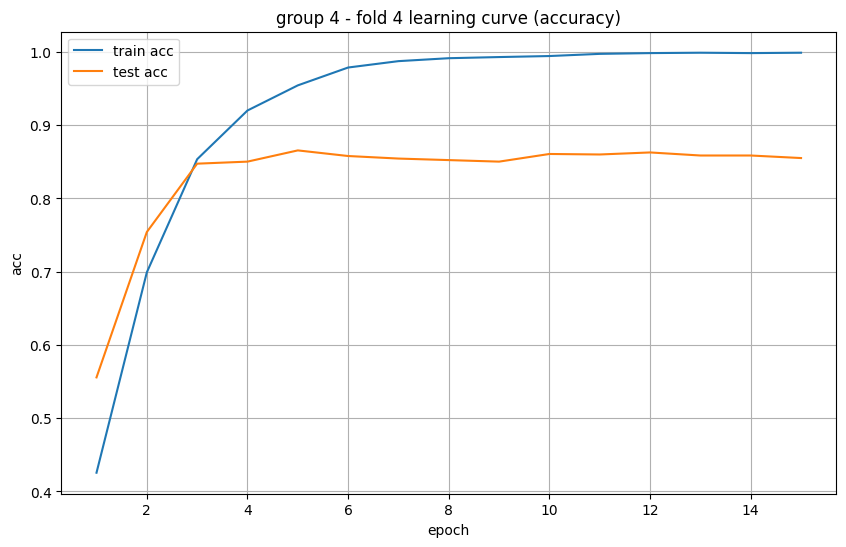

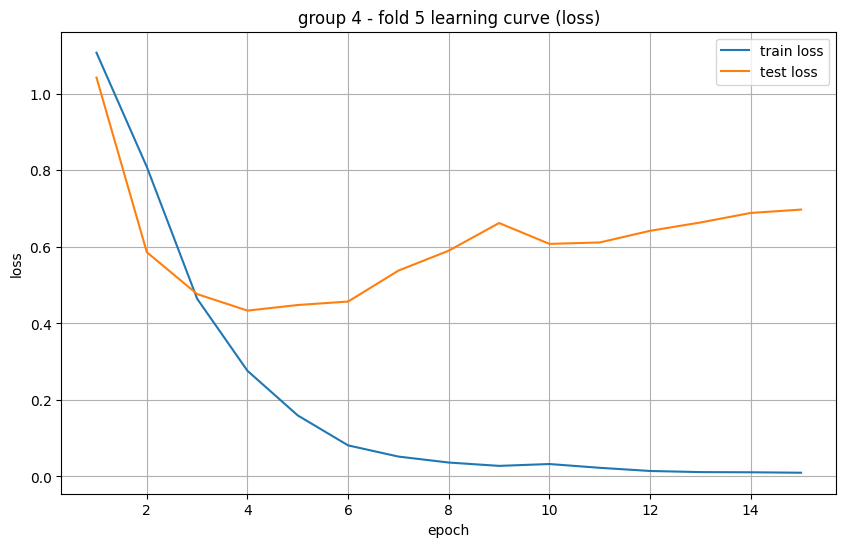

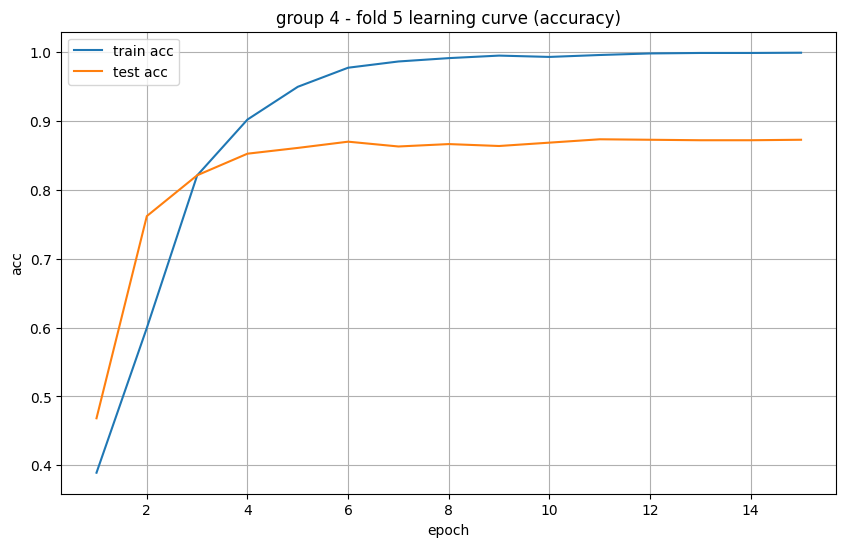

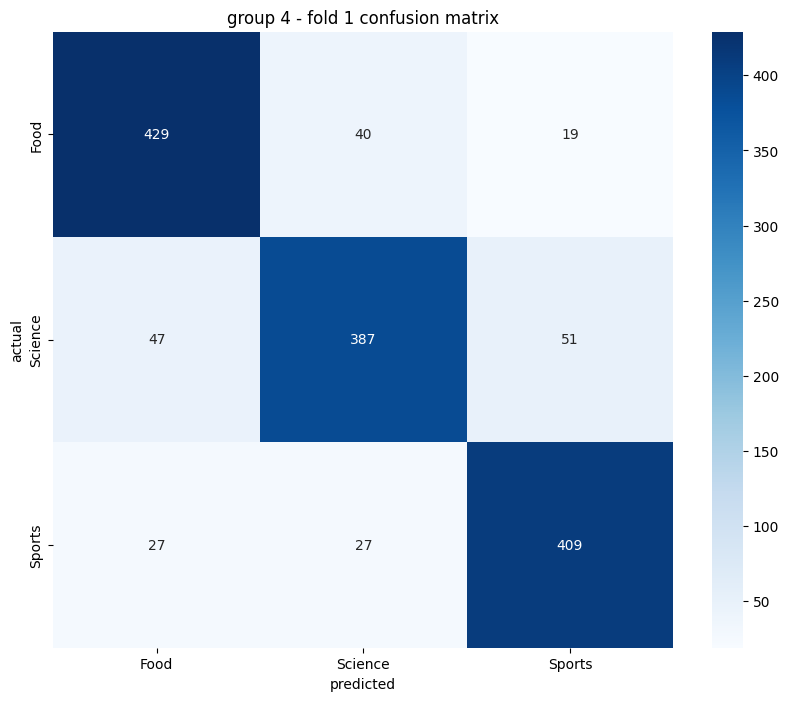

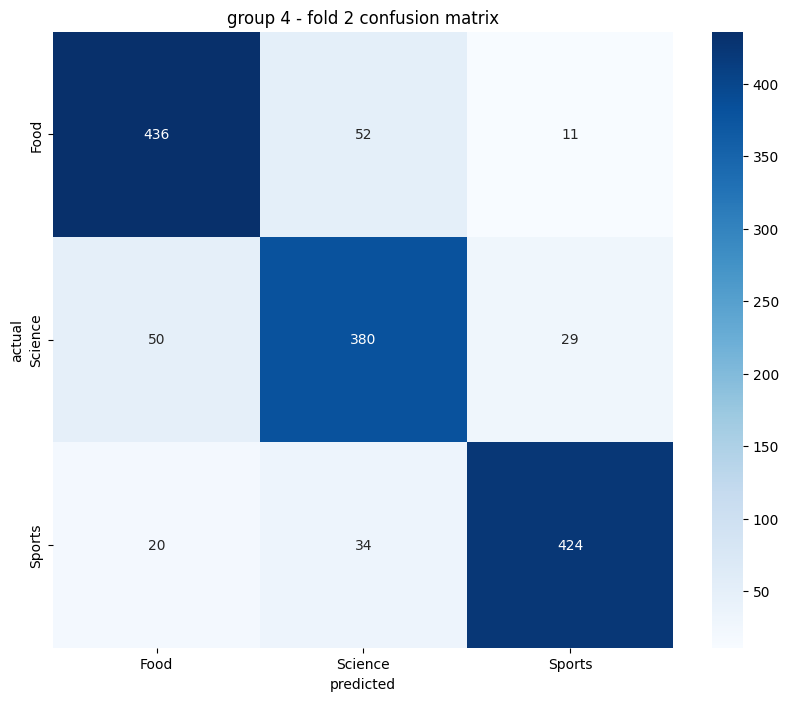

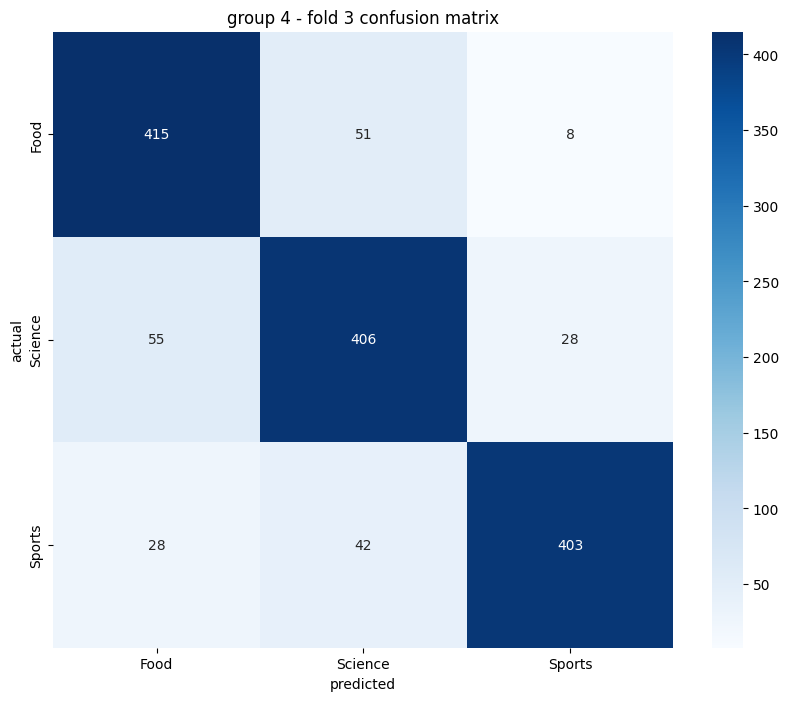

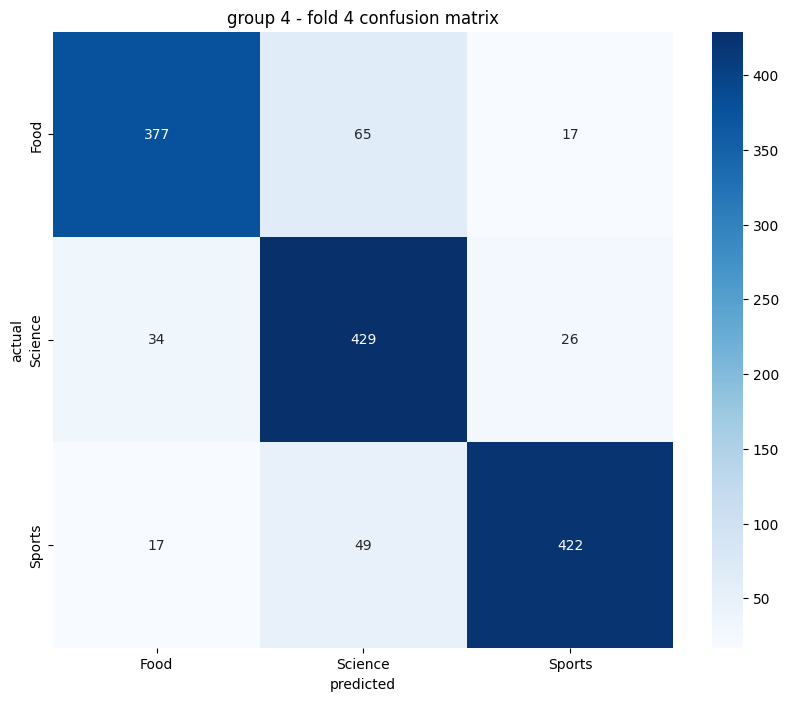

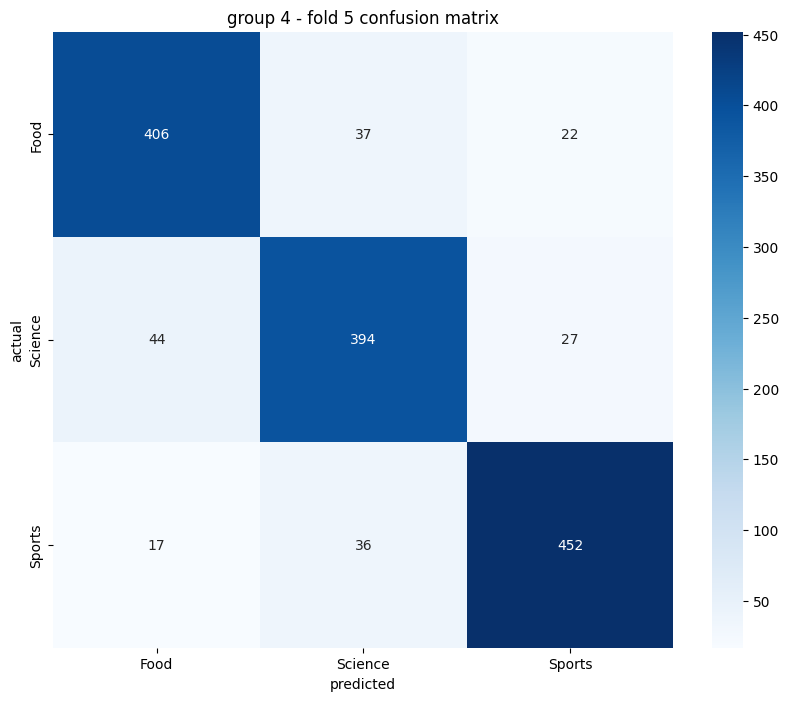


group 5 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9905, train acc: 0.4827
                               test loss: 0.7384, test acc: 0.6921
    epoch 5/15: train loss: 0.2176, train acc: 0.9246
                               test loss: 0.4401, test acc: 0.8509
    epoch 10/15: train loss: 0.0451, train acc: 0.9900
                               test loss: 0.7244, test acc: 0.8432
    epoch 15/15: train loss: 0.0164, train acc: 0.9972
                               test loss: 0.7887, test acc: 0.8509

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0346, train acc: 0.4375
                               test loss: 0.6757, test acc: 0.7460
    epoch 5/15: train loss: 0.1963, train acc: 0.9347
                               test loss: 0.4141, test acc: 0.8628
    epoch 10/15: train loss: 0.0389, train acc: 0.9902
                               test loss: 0.6449, test acc: 0.8593
    epoch 15/15: train loss: 0.0112, train acc: 0.9981
                               test lo

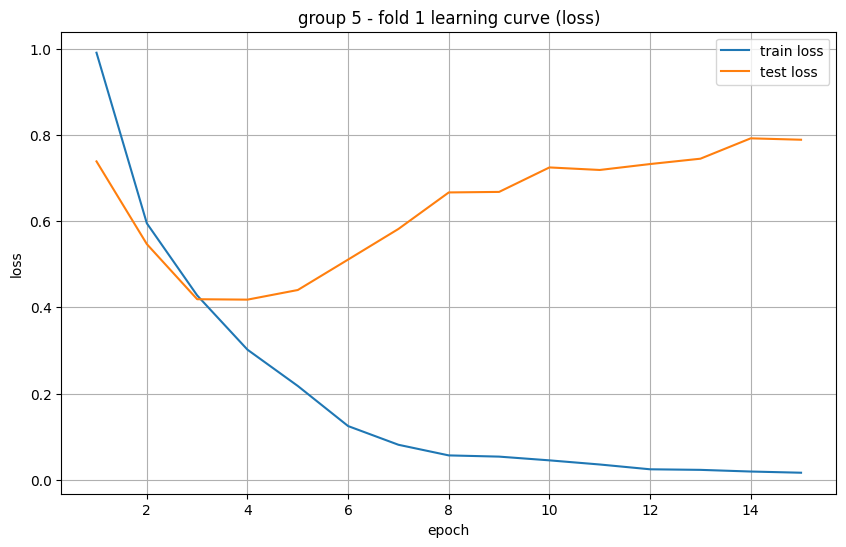

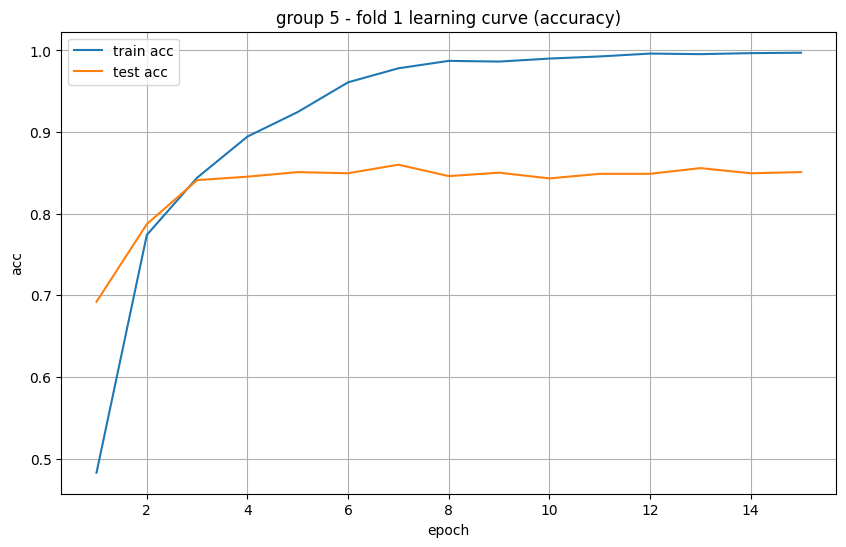

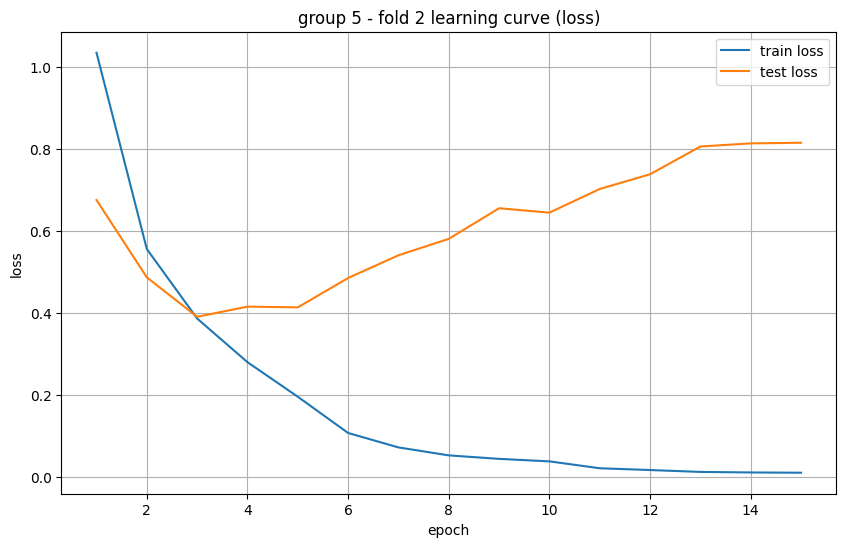

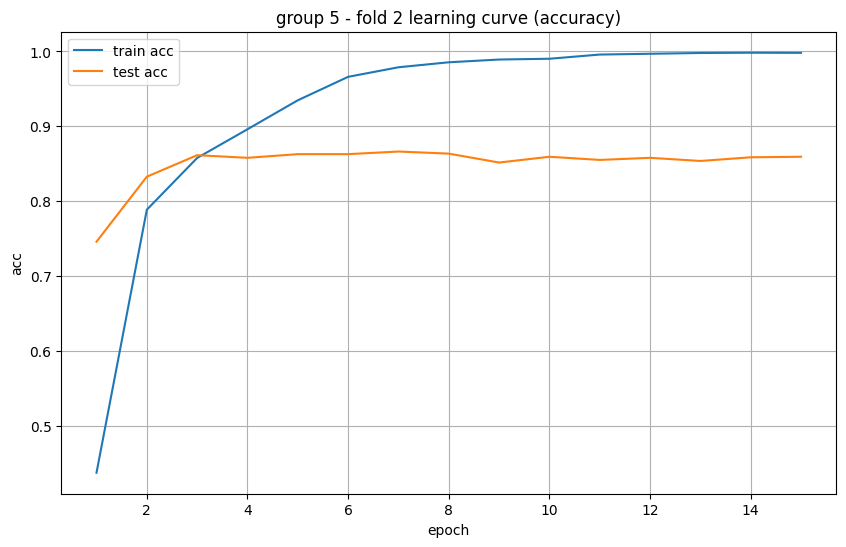

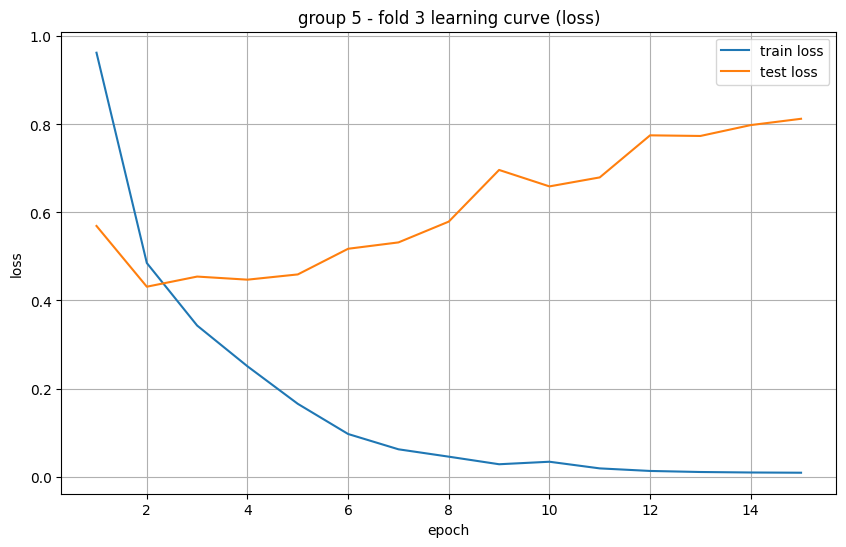

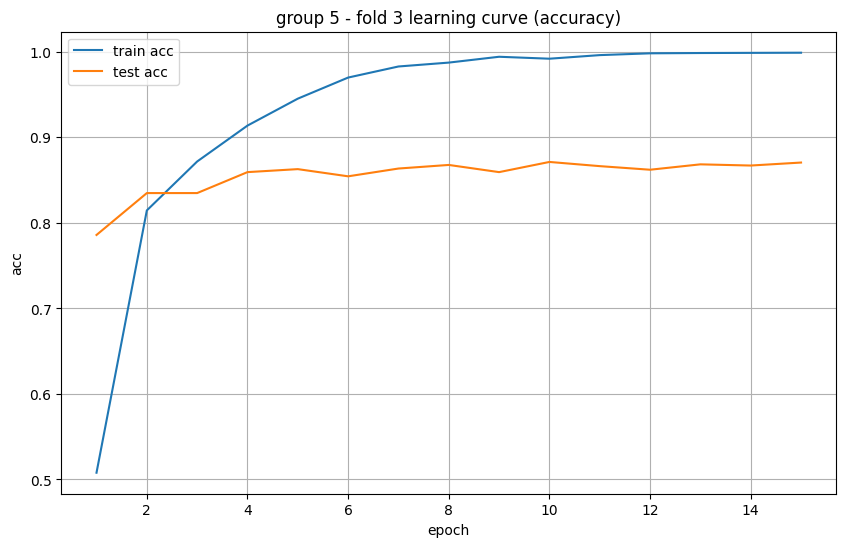

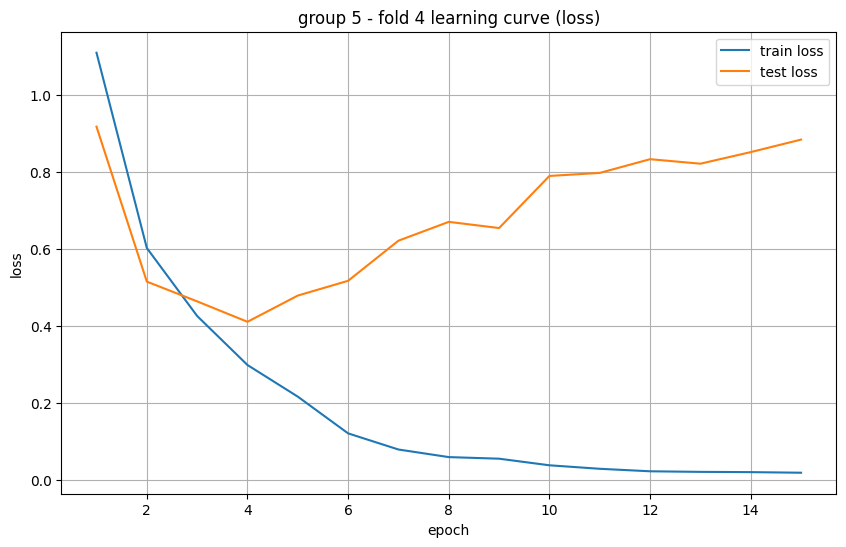

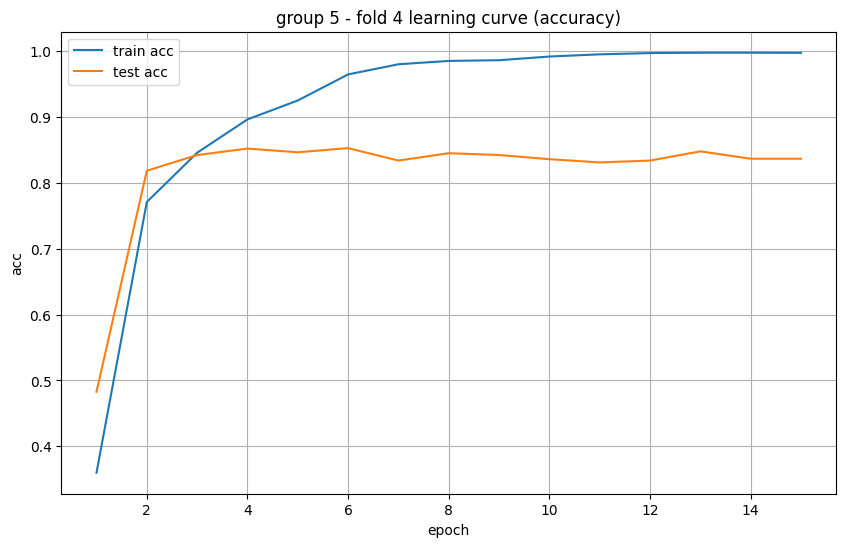

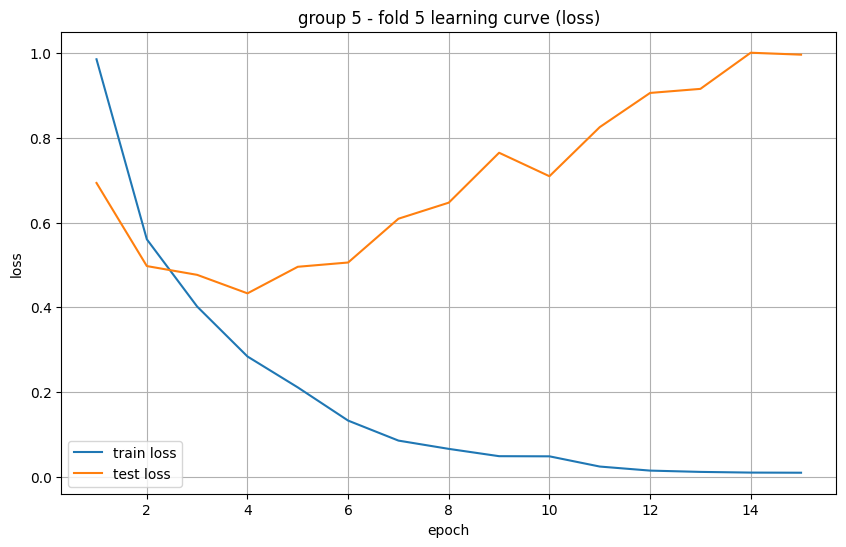

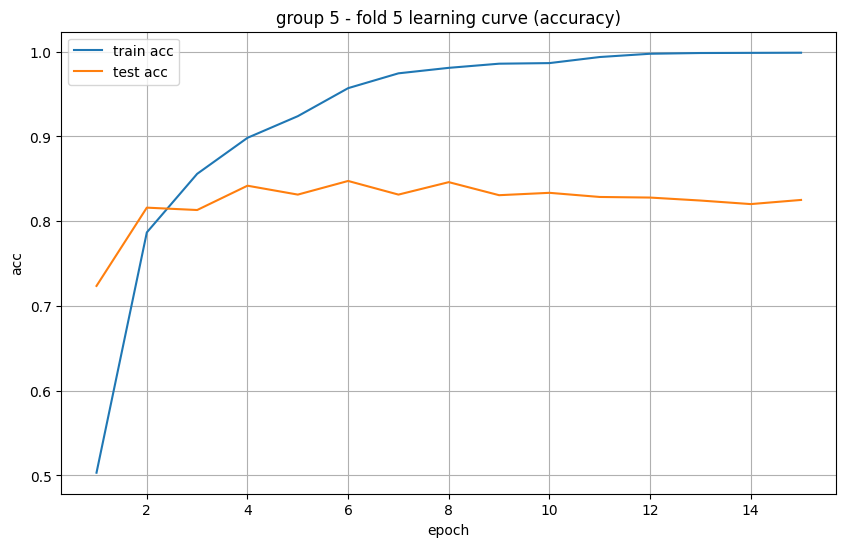

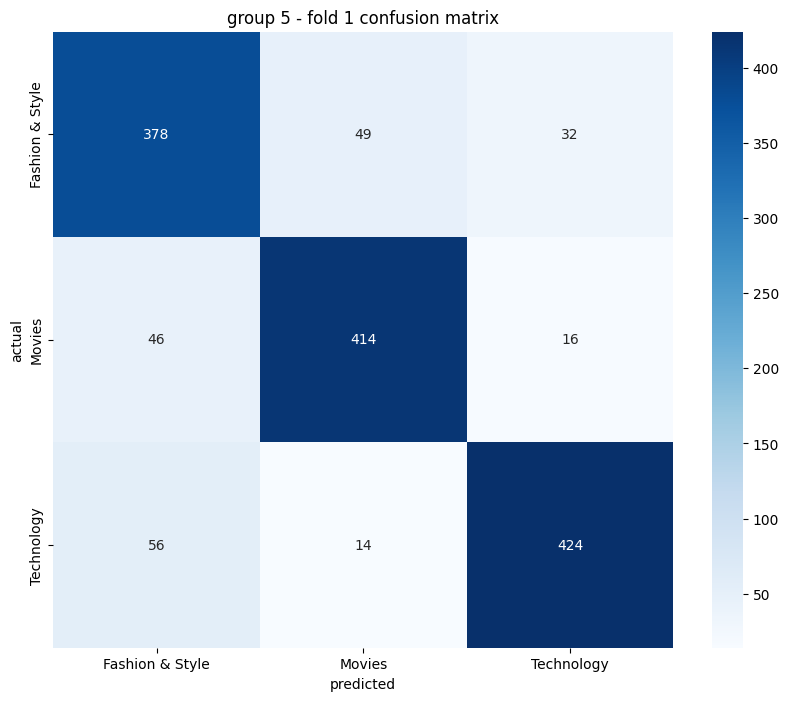

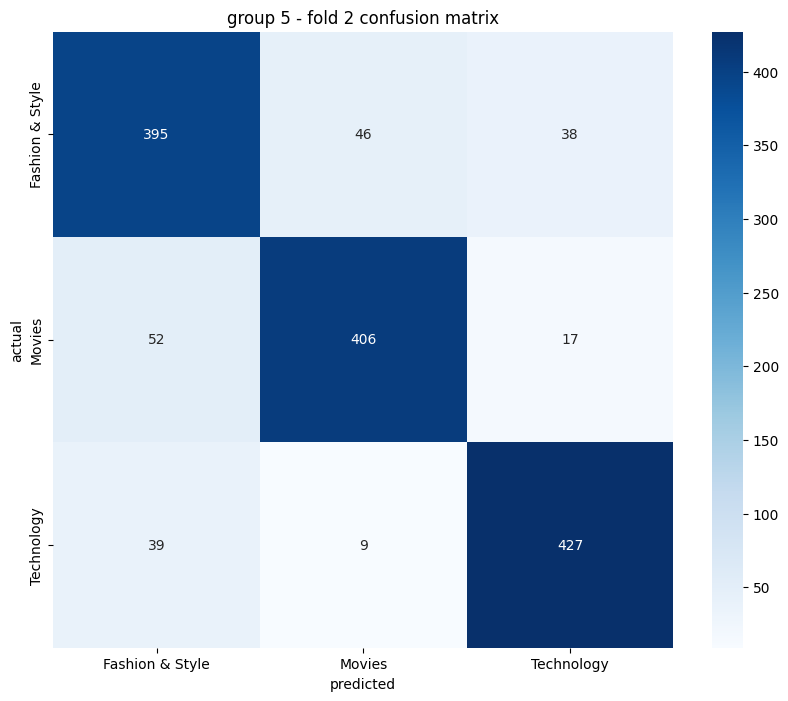

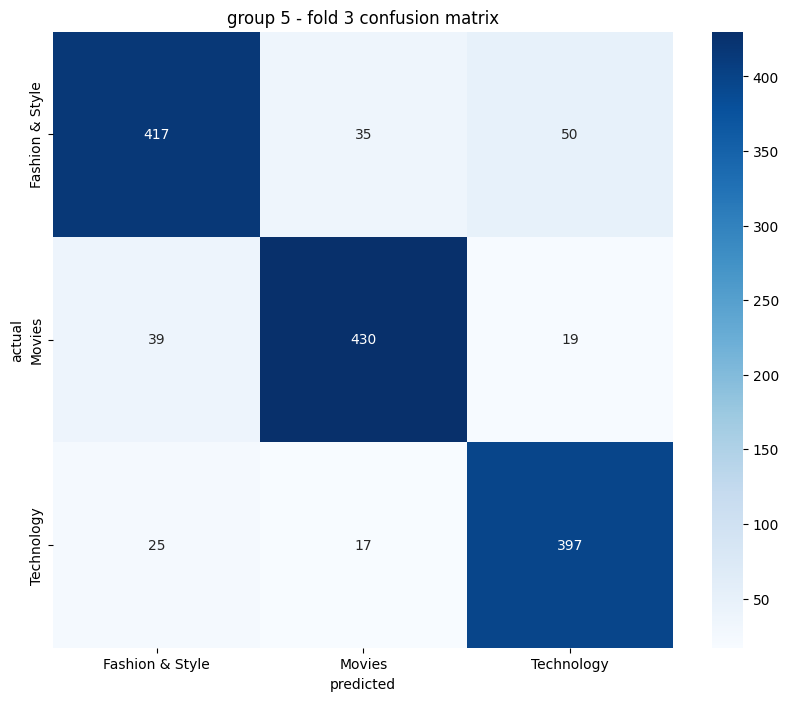

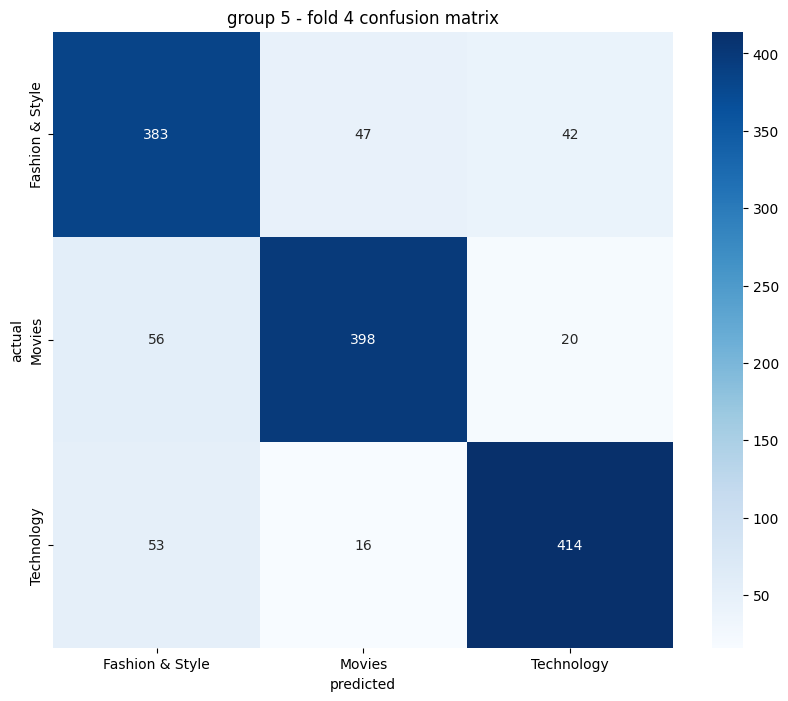

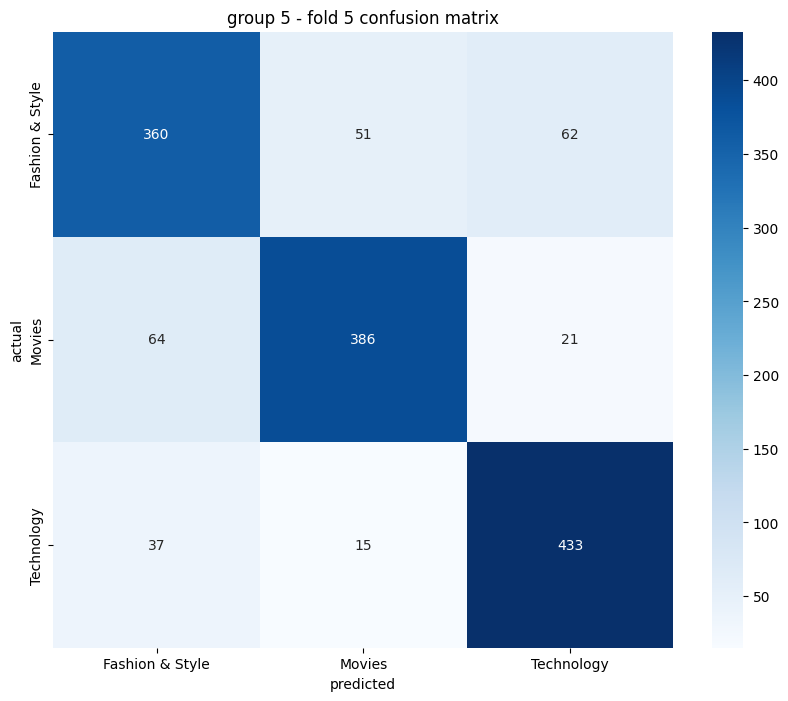


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0904, train acc: 0.3909
                               test loss: 0.9551, test acc: 0.5549
    epoch 5/15: train loss: 0.3006, train acc: 0.8916
                               test loss: 0.6069, test acc: 0.7775
    epoch 10/15: train loss: 0.0629, train acc: 0.9831
                               test loss: 1.0302, test acc: 0.7665
    epoch 15/15: train loss: 0.0264, train acc: 0.9935
                               test loss: 1.3005, test acc: 0.7622

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0461, train acc: 0.4213
                               test loss: 0.7268, test acc: 0.6749
    epoch 5/15: train loss: 0.2845, train acc: 0.9016
                               test loss: 0.5498, test acc: 0.8036
    epoch 10/15: train loss: 0.0616, train acc: 0.9833
                               test loss: 0.9587, test acc: 0.7927
    epoch 15/15: train loss: 0.0186, train acc: 0.9973
                               test lo

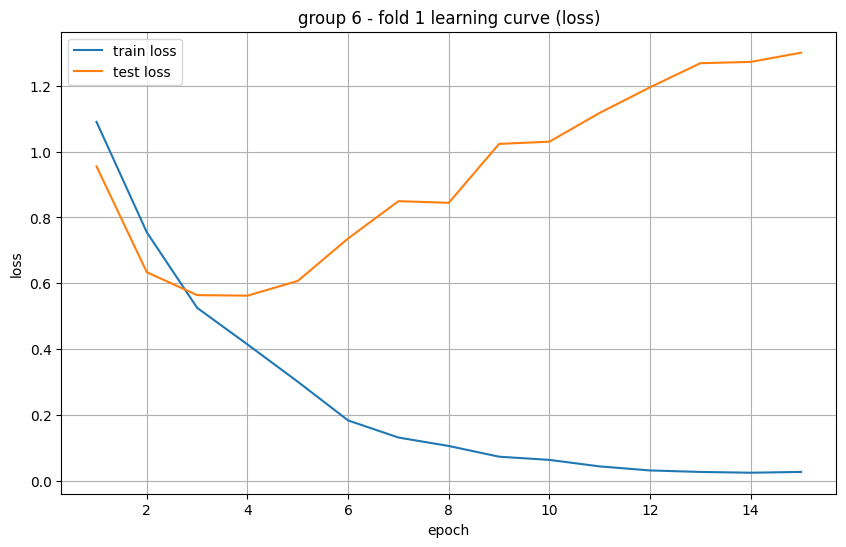

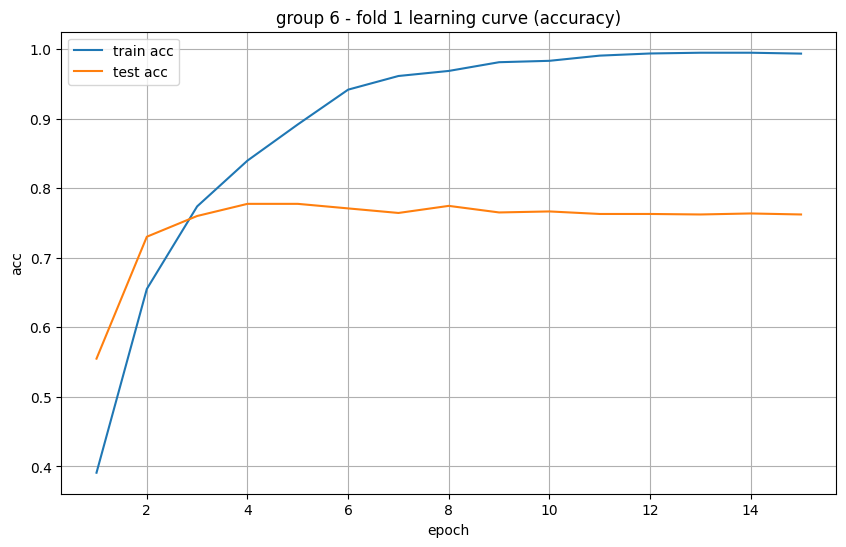

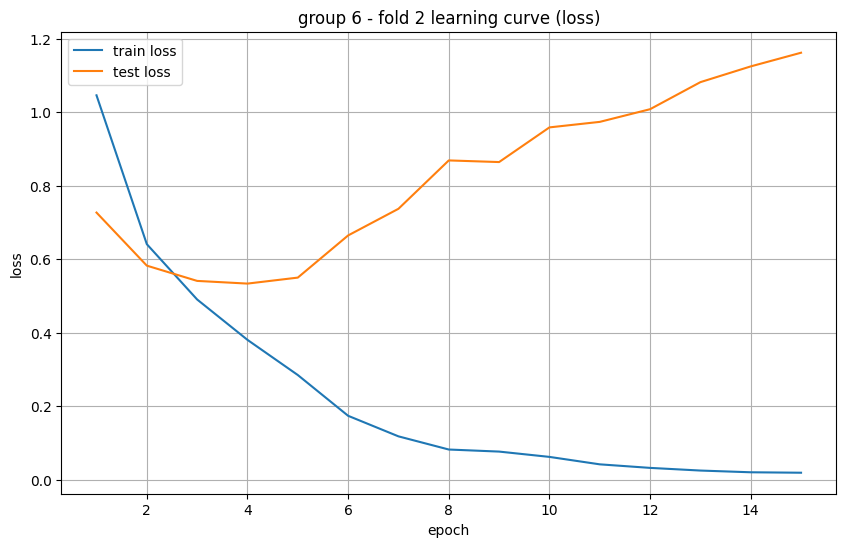

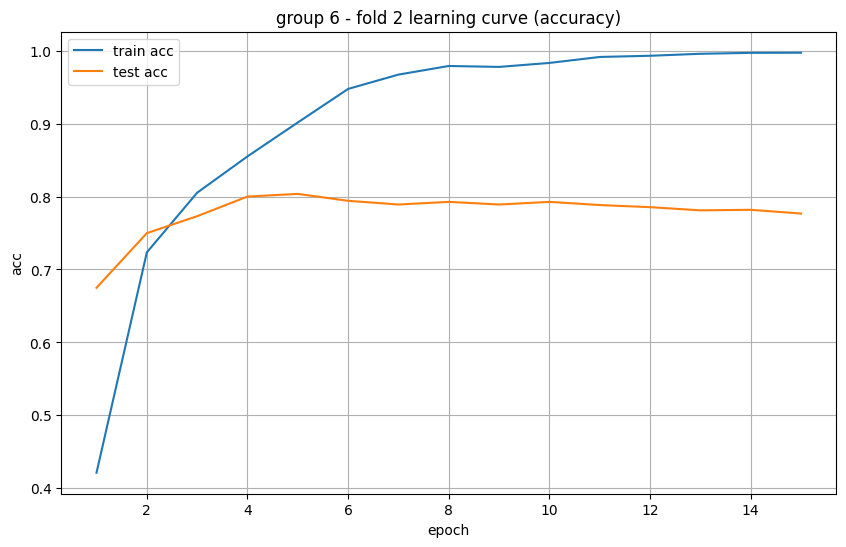

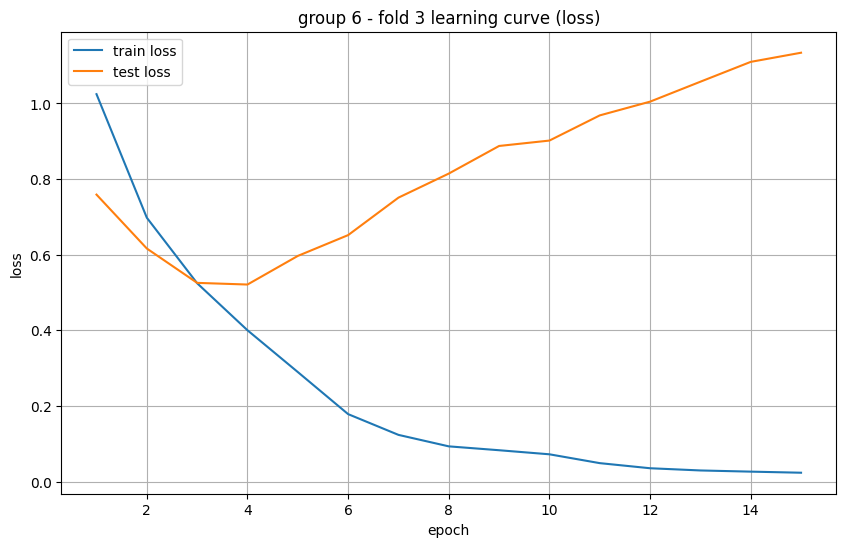

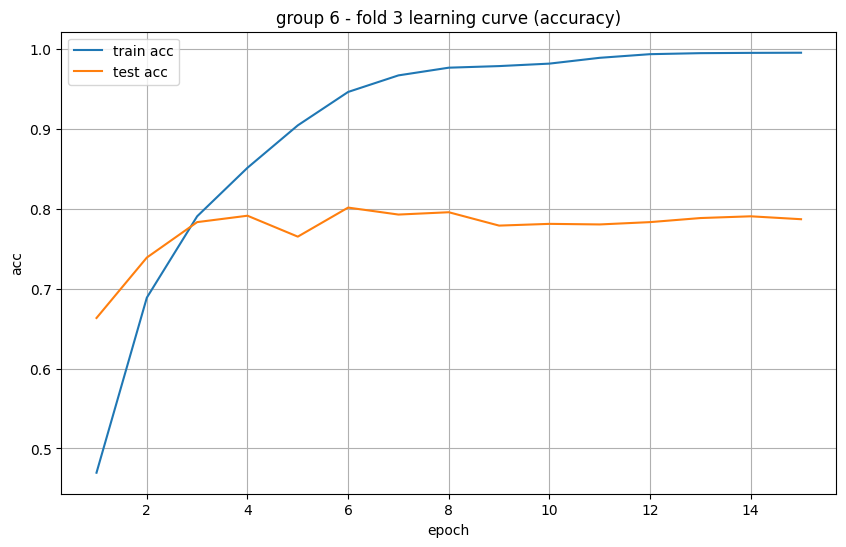

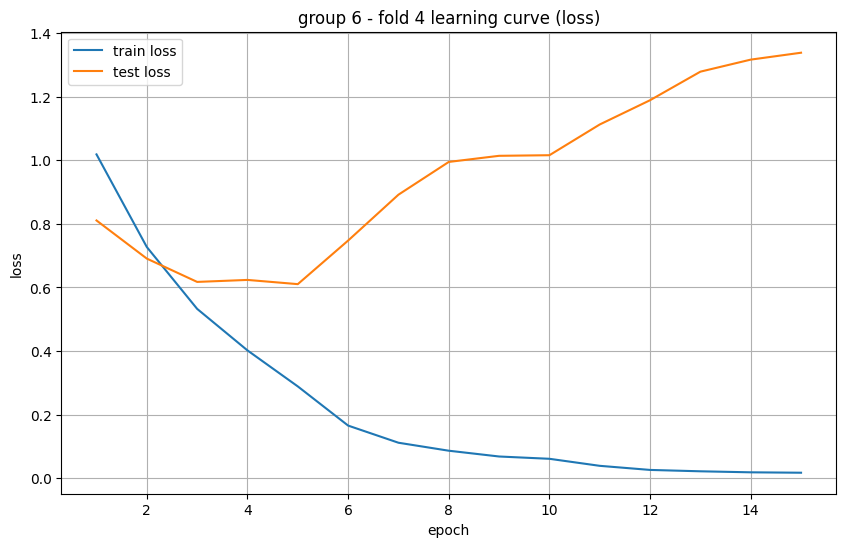

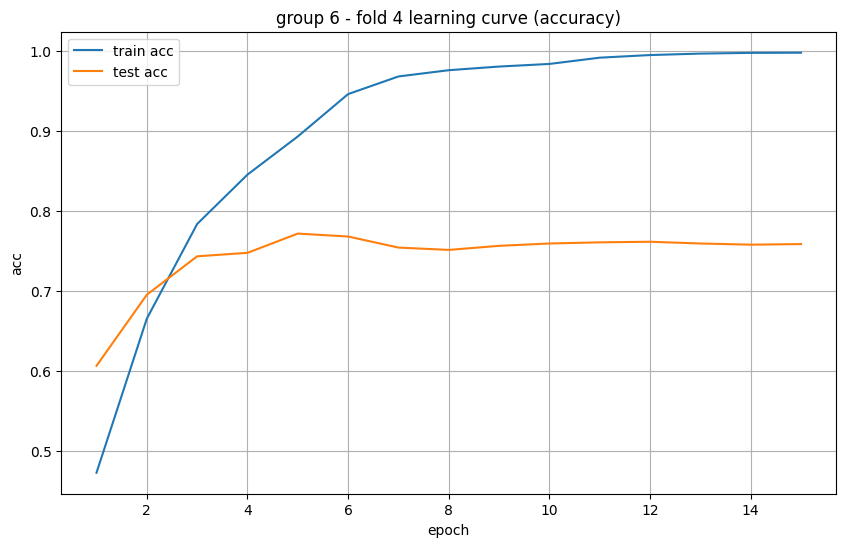

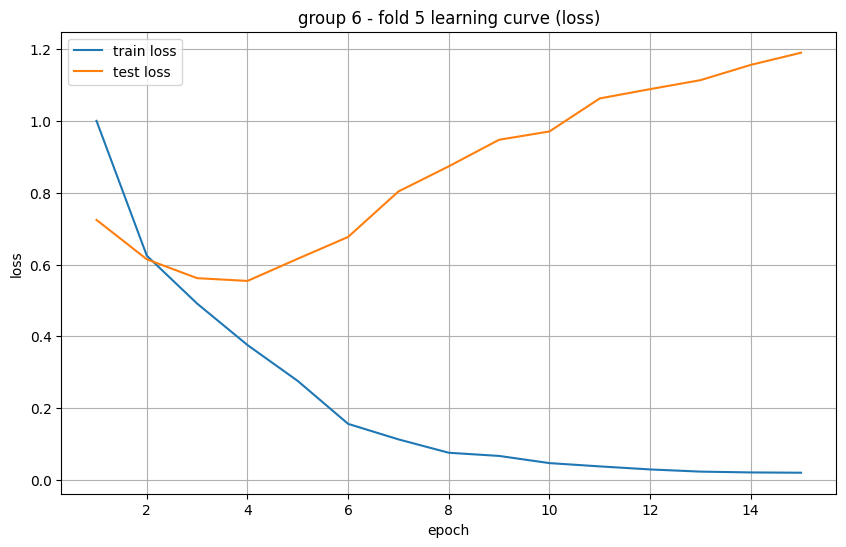

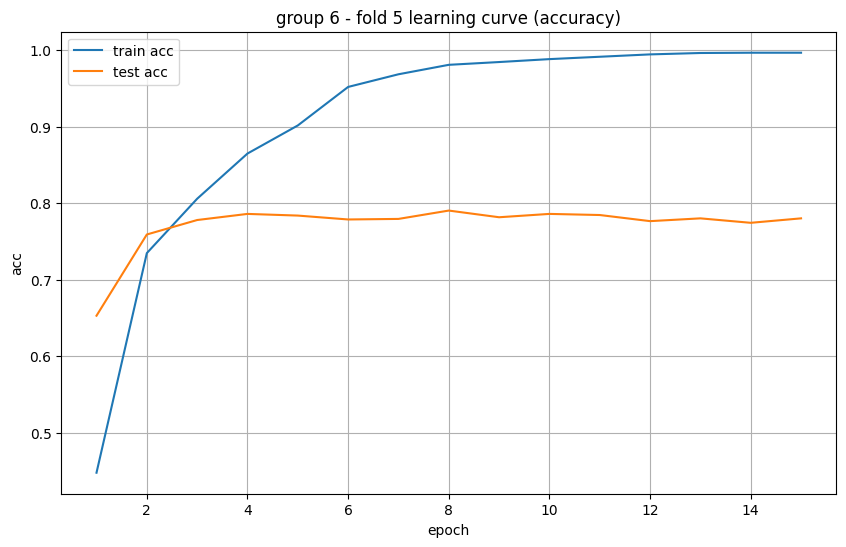

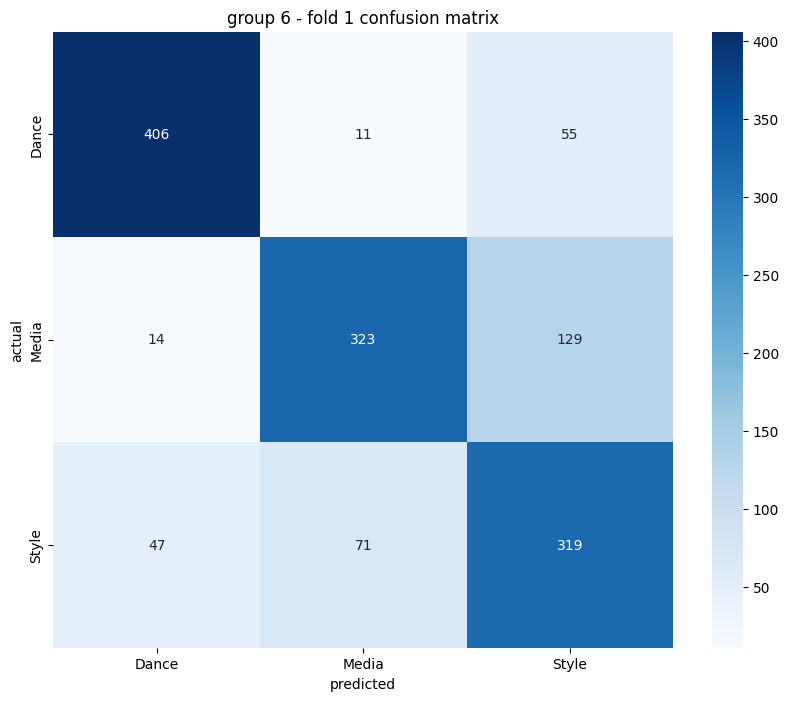

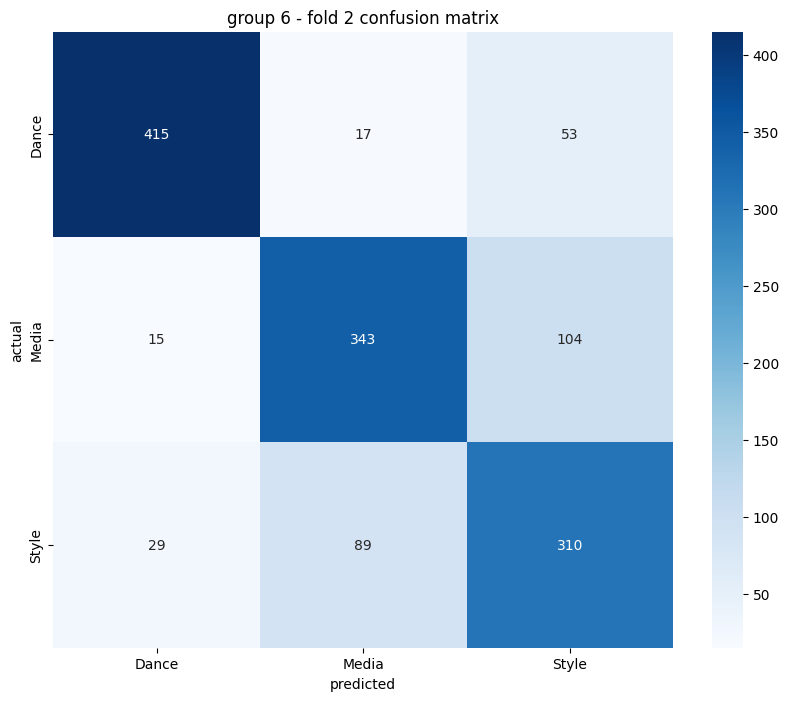

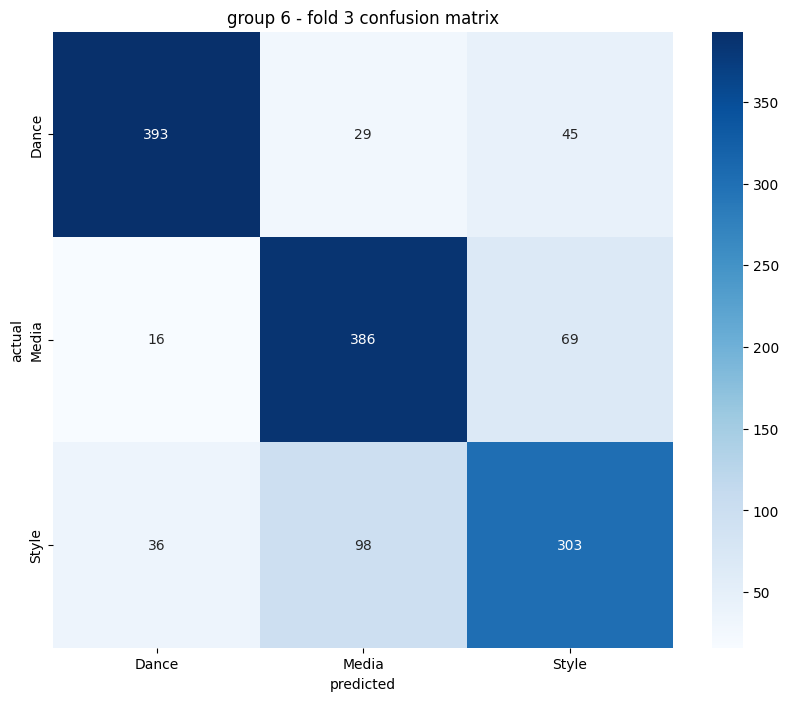

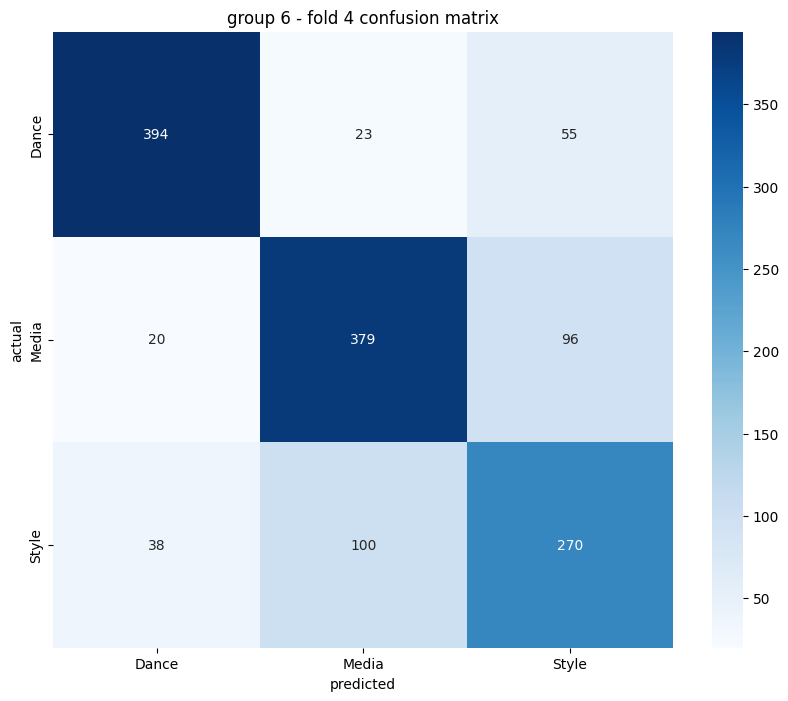

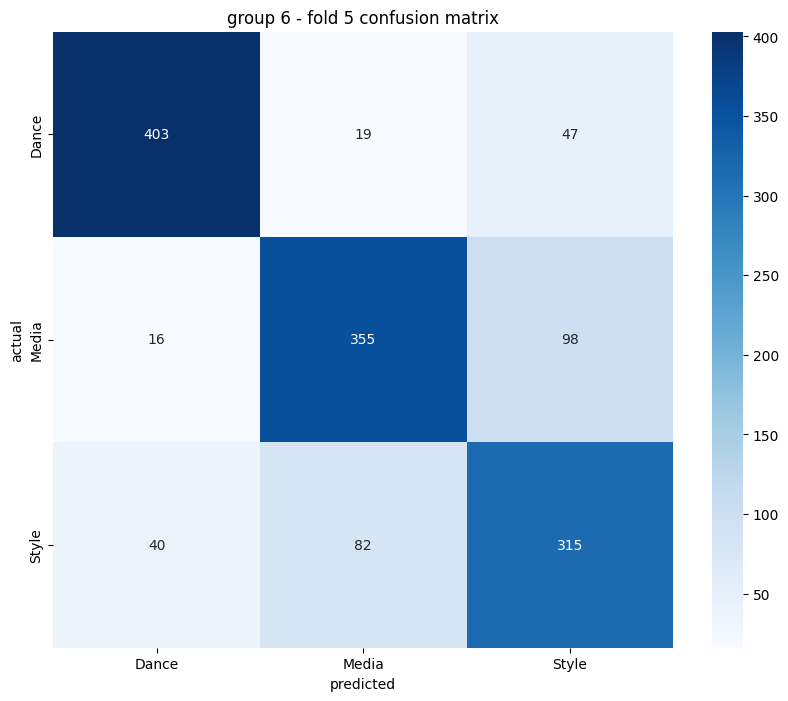


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8383
  폴드 1: 테스트 정확도 = 0.8519
  폴드 2: 테스트 정확도 = 0.8498
  폴드 3: 테스트 정확도 = 0.8346
  폴드 4: 테스트 정확도 = 0.8325
  폴드 5: 테스트 정확도 = 0.8229

그룹 2 - 평균 테스트 정확도: 0.8067
  폴드 1: 테스트 정확도 = 0.8171
  폴드 2: 테스트 정확도 = 0.8102
  폴드 3: 테스트 정확도 = 0.7942
  폴드 4: 테스트 정확도 = 0.8156
  폴드 5: 테스트 정확도 = 0.7963

그룹 3 - 평균 테스트 정확도: 0.8326
  폴드 1: 테스트 정확도 = 0.8237
  폴드 2: 테스트 정확도 = 0.8250
  폴드 3: 테스트 정확도 = 0.8278
  폴드 4: 테스트 정확도 = 0.8423
  폴드 5: 테스트 정확도 = 0.8444

그룹 4 - 평균 테스트 정확도: 0.8593
  폴드 1: 테스트 정확도 = 0.8531
  폴드 2: 테스트 정확도 = 0.8635
  폴드 3: 테스트 정확도 = 0.8524
  폴드 4: 테스트 정확도 = 0.8552
  폴드 5: 테스트 정확도 = 0.8725

그룹 5 - 평균 테스트 정확도: 0.8484
  폴드 1: 테스트 정확도 = 0.8509
  폴드 2: 테스트 정확도 = 0.8593
  폴드 3: 테스트 정확도 = 0.8705
  폴드 4: 테스트 정확도 = 0.8362
  폴드 5: 테스트 정확도 = 0.8251

그룹 6 - 평균 테스트 정확도: 0.7729
  폴드 1: 테스트 정확도 = 0.7622
  폴드 2: 테스트 정확도 = 0.7767
  폴드 3: 테스트 정확도 = 0.7869
  폴드 4: 테스트 정확도 = 0.7585
  폴드 5: 테스트 정확도 = 0.7804


In [8]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(best_valid_loader, f) 
    print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")